# **Projet Python 2A**

**Tony Lauze - Fanny Daubet**

*Ce projet est réalisé dans le cadre du cours de Python pour la data-science de Lino Galiana, pour l'année 2023-2024.*


## **Introduction**

Le but de ce projet est de **modéliser le prix de l'immobilier en région parisienne** et, plus précisément, des appartements dans Paris intra-muros.

La base de donnée principale qui sera utilisée, est le **fichier Demandes de Valeurs Foncières (DVF)**, produit par la direction générale des finances publiques, qui recense les transactions immobilières intervenues au cours des cinq dernières années en France, à partir des actes notariés.

Comme toutes les ventes de ce fichier sont géolocalisées, l'enrichissement principal qui sera apporté à la base de données sera l'ajout, pour chaque appartement, de la **distance minimale à certains lieux d'intérêt parisiens** (stations de métro, espaces verts, lieux historiques, etc.).

Pour la modélisation, on procédera d'abord à une approche "économétrique" utilisant des régressions simples et des régressions avec effets fixes, puis on abordera le problème d'un point de vue plus orienté prédiction et sélection de variables, avec les régressions LASSON et RIDGE (dont on verra les limites dans notre cas).

Les grandes étapes sont donc les suivantes :
- Etape 1 : Prise en main et nettoyage du fichier DVF, création d'une base de données de départ
- Etape 2 : Visualisation spatiale et temporelle
- Etape 3 : Enrichissement des données, en récupérant en open data et scrapping les localisations de plusieurs catégories de lieux d'intérêt parisiens
- Etape 4 : Modélisation, approche économétrique et prédiction

## **I) Nettoyage des données**

### **1) Nettoyage**

Les fichiers DVF bruts pour le département 75 (Paris intra-muros) peuvent être trouvés dans le dossier `0) Données brutes`. Les principales variables renseignées dans ce fichier sont :

- `id_mutation` : Identifiant de mutation (non stable, sert à grouper les lignes)
- `date_mutation` : Date de la mutation au format ISO-8601 (YYYY-MM-DD)
- `valeur_fonciere` : Valeur foncière (séparateur décimal = point)
- `lot_1_numero` : Numéro du lot 1, qui nous servira pour le nettoyage
- `lot_1_surface_carrez` : Surface Carrez du lot 1
- `type_local` : Libellé du type de local (appartement, local commercial, maison, dépendance)
- `surface_reelle_bati` : Surface réelle du bâti
- `nombre_pieces_principales` : Nombre de pièces principales
- `longitude` : Longitude du centre de la parcelle concernée (WGS-84)
- `latitude` : Latitude du centre de la parcelle concernée (WGS-84)

Le code utilisé pour nettoyer les fichiers étant fastidieux, et l'exécution assez longue, cette étape sera seulement résumée ici, et quelques fonctions principales exhibées, mais le code complet peut être consulté dans le dossier `1.0) Nettoyage` dans le notebook `Nettoyage.ipynd`.

Le but du nettoyage était le suivant :

D'abord, se restreindre aux ventes d'appartement, afin d'isoler un marché plus homogène que l'immobilier en général. Pour ce faire, il s'agissait de retirer les ventes de maisons et de locaux commerciaux, en prenant garde aux ventes groupées qui pouvaient survenir (par exemple, une vente d'un appartement et d'un local commercial) : il fallait donc retier, dans ce cas, toutes les lignes corresponant à l'identifiant de vente problématique. 

La fonction suivante permet ce traitement :

In [1]:
def retirer_maison_locaux(df):
    
    #on regroupe les identifiants de vente en comptant le nombre de maisons et de locaux
    ventes_group = df.groupby('id_mutation').agg({'maison_ind': 'sum', 'local_ind': 'sum'})
    
    #on localise les identifiants des ventes où il y a une maison ou un local
    ventes_a_supp = ventes_group.loc[(ventes_group['maison_ind']>0) | (ventes_group['local_ind']>0)] 

    #on convertit en dataframe
    ventes_a_supp = pd.DataFrame(ventes_a_supp) 

    #on créée la liste des ventes à supprimer en récupérant l'index
    list_ventes_a_supp = ventes_a_supp.index.tolist() 

    #on retire les ventes 
    df = df.set_index('id_mutation') #on passe l'id_de vente en index
    df = df.drop(list_ventes_a_supp) #on drop tous les id présents dans la liste à supprimer

    #on repasse l'identifiant de mutation en colonne et on reset l'index
    df = df.reset_index()

    return df

Ensuite, il s'agissait d'ajouter aux appartement le nombre de leurs dépendances (balcons, cave, garage, etc.). Ici, un traitement différencié selon les années était nécessaire.

Pour les fichiers 2022 et 2023, la variable `lot1_numero` permet, quand il y a une vente contenant par exemple 2 appartements et 5 dépendances, de retrouver quelles dépendances sont associées à chacun des appartements, en les associant selon leur numéro de lot. 

Mais pour les fichiers d'avant 2022, la variable `lot1_numero` ne permet plus ce traitement. Il fallait alors se restreindre aux ventes qui contenaient un seul appartement, et associer à ce dernier toutes les éventuelles dépendances contenues dans la vente.

Egalement, pour les ventes groupées qui contiennnet plus d'un appartement, il n'y a pour ces appartements qu'un seul prix renseigné dans la colonne `valeur_fonciere`. On associe donc à chaque appartement son prix individuel, en faisant un prorata selon la surface renseignée dans la colonne `surface_reelle_bati`.

La fonction suivante permet ce traitement, pour le cas des années 2022 et 2023 :

In [2]:
def nettoyage_vente_2022_2023(id, df):
    #id : indice de la vente
    #df : dataframe
    
    mini_df = df.loc[(df['id_mutation']==id)] #on récupère la vente
    mini_df_appart = df.loc[(df['id_mutation']==id) & (df['appartement_ind']==1)] #on récupère les appartements de cette vente
    index_app = mini_df_appart.index.tolist() #index des appartements
    
    nb_tot_app = mini_df_appart['appartement_ind'].sum() #nombre total d'appartments dans la vente
    
    if nb_tot_app > 1: #s'il y a au moins un appartement dans la vente, on essaie de récupérer pur chaque appart. la surface du lot associé
        
        mini_df_group_lot_dep = mini_df.groupby('lot1_numero').sum()['dependance_ind'] #pour chaque numéro de lot, on récupère le nombre de dépendance

        #pour chaque appartement dans la vente, on met à jour les informations du nombre de dépendance
        for index in index_app:
            num_lot = mini_df.loc[index,'lot1_numero'] #on récupère le numéro de lot associé à l'appartement
            nb_dépendance = mini_df_group_lot_dep[num_lot] #on récupère le nombre de dépendances
            df.loc[index,'nombre_dependances']=nb_dépendance #on met à jour le dataframe

        #enfin, on met à jour le prix
        
        if nb_tot_app > 1: #s'il y a plus d'un appartement dans la vente, on met à jour le prix au prorata de la surface réelle
            surface_totale = mini_df_appart['surface_reelle_bati'].sum() #surface réelle totale
            prix_lot = mini_df_appart.loc[index_app[0]]['valeur_fonciere'] #on récupère la valeur foncière totale
            
            for index in index_app: #pour chaque appartement, on fait le prorata selon sa surface réelle
                surface_app = mini_df_appart.loc[index]['surface_reelle_bati'] #on récupère la surface de l'appartement
                df.loc[index, 'prix'] = prix_lot*(surface_app)/(surface_totale) #on met à jour le prix
                
        else: #si un seul appartement, rien à faire
            pass
            
    elif nb_tot_app == 1: #s'il y a un seul appartement dans la vente, on lui ajoute toutes les dépendances de la vente
        
        nb_dep = mini_df['dependance_ind'].sum()
        
        df.loc[index_app[0],'nombre_dependances']=nb_dep #on met à jour le dataframe
            
    else: #si aucun appartement dans la vente, rien à faire
        pass

On pouvait également ajouter, pour les appartements où elle était renseignée dans la colonne `lot_1_surface_carrez`, la surface en loi carrez. Puis, calculer le prix au m^2, soit selon la surface réelle du bâti, soit selon la surface en loi carrez. 

Enfin, on se restreint aux appartements pour lesquels on a bien une surface, une localisation, un prix.

Toutes ces étapes, ainsi que l'élimination des variables inutiles et le renommage de certaines, sont effectuées par les fonctions :

- `nettoyage_2022_2023` pour les fichiers DVF de 2022 et 2023
- `nettoyer_avant_2022` pour les fichiers DVF antérieurs

Les données nettoyées sont exportées (en .csv) dans le dossier `1.1) Données clean`.

### **2) Concaténation des années**

On concatène ensuite les fichiers DVF des différentes années, et on en profite pour retirer les valeurs extrêmes pour les variables numériques d'intérêt (prix, surface, prix au m^2,, nombre de pièces), et pour convertir le fichier en Geodataframe. Cela est effectué dans le notebook `Concaténer.ipynb` du dossier `1.2) Données concat`.

Le passage en Geodataframe permet également d'ajouter le quartier parisien auquel appartient l'appartement, grâce à la fonction `sjoin` de la bibliothèque Geopandas et aux données administratives des arrondissements et des quartiers parisiens, qui se trouvent ici : `Projet-python-2A/2) Visualisation/Données_carto`

Au final, on obtient donc dans le dossier `1.2) Données concat` un fichier `dvf_concat_total.geojson` qui sera notre base de travail, notamment pour la visualisation.

## **II) Visualisation**

Le but de cette partie est de visualiser (spatialement et temporellement) les données du fichier DVF, pour vérifier qu'elles sont bien conformes à l'intuition et pour engranger déjà quelques idées en vue de la modélisation.

Les codes des fonctions utilisées dans cette partie sont dans le fichier `Visualisation.py`, on n'en montrera qu'une partie pour ne pas alourdir le compte-rendu.

### **1) Evolution temporelle**

Dans un premier temps, on va observer l'évolution temporelle du prix de l'immobilier, et du nombre de ventes, en région parisienne.

In [252]:
"""Librairies nécessaires"""
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
from shapely.geometry import Point 

"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-python-2A')

"""Récupération des données DVF"""
path_dvf = '1.2) Données concat/dvf_concat_total.geojson'
dvf = gpd.read_file(path_dvf)

In [254]:
"""Première lignes du fichier DVF"""
dvf.head(3)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,adresse_numero,adresse_nom_voie,code_postal,code_commune,nom_arrondissement,num_arrondissement,nom_quartier,longitude,latitude,geometry
0,2018-743587,2018-07-02,372000.0,12.826649,2.0,35.0,35.52,0.0,10473.0,10629.0,35.0,RUE NOTRE DAME DE NAZARETH,75003,75103,Paris 3e Arrondissement,03,Arts-et-Métiers,2.358136,48.867319,POINT (2.35814 48.86732)
1,2018-743594,2018-07-03,216500.0,12.285346,1.0,24.0,21.10,0.0,10261.0,9021.0,1.0,RUE JEAN MERMOZ,75008,75108,Paris 8e Arrondissement,08,Faubourg-du-Roule,2.310473,48.870036,POINT (2.31047 48.87004)
2,2018-743596,2018-07-05,347500.0,12.758520,2.0,35.0,31.95,1.0,10876.0,9929.0,219.0,RUE SAINT MARTIN,75003,75103,Paris 3e Arrondissement,03,Sainte-Avoie,2.352721,48.864270,POINT (2.35272 48.86427)


In [260]:
"""Evolution du prix moyen des appartements vendus, à une fréquence mensuelle"""

def evolution_prix_mensuel(dvf):
    
    #dvf : dataframe avec une colonne date_mutation et prix

    #ne garder que les colonnes utiles
    dvf = dvf.loc[:,['prix', 'date_mutation']]
    
    # Création d'une colonne date_time au format datetime
    dvf['date_time'] = pd.to_datetime(dvf['date_mutation'])
    
    # Conversion de la colonne 'date_time' en format de période mensuelle
    dvf['mois'] = dvf['date_time'].dt.to_period('M')
    
    # Grouper par mois et calculer la moyenne des prix
    dvf_grouped = dvf.groupby('mois')['prix'].mean().reset_index()
    
    # Tracer l'évolution mensuelle des prix
    plt.figure(figsize=(8, 5))
    plt.plot(dvf_grouped['mois'].astype(str), dvf_grouped['prix'], marker='o', linestyle='-', color='b')
    
    # Diminuer la fréquence des étiquettes sur l'axe des x
    n = len(dvf_grouped['mois'])
    step = max(1, n // 10)  #à ajuster
    plt.xticks(dvf_grouped.index[::step], dvf_grouped['mois'].iloc[::step], rotation=45, ha='right')
    
    # Ajouter des étiquettes et un titre
    plt.xlabel('Mois')
    plt.ylabel('Prix moyen')
    plt.title('Évolution Mensuelle du prix moyen des appartements vendus à Paris depuis 2018')
    
    # Afficher la grille
    plt.grid(True)
    
    # Afficher le graphique
    plt.show()

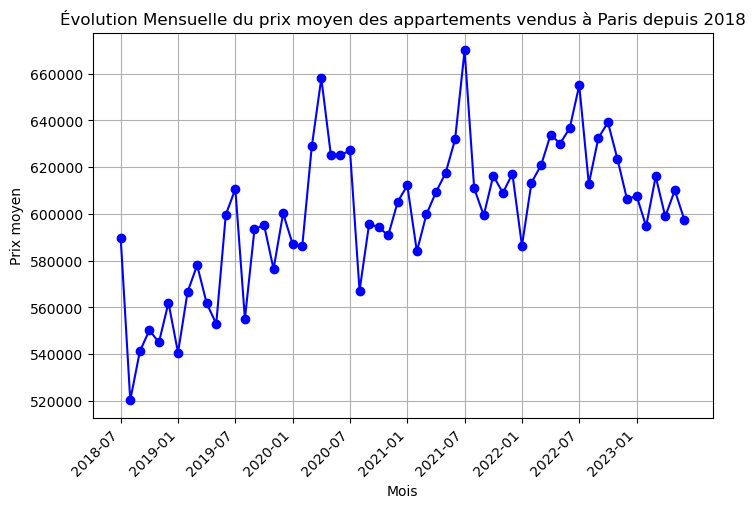

In [261]:
"""Application de la fonction"""
evolution_prix_mensuel(dvf)

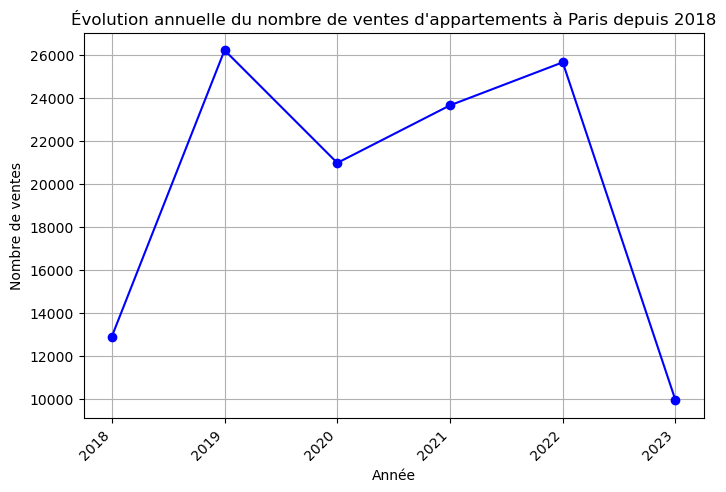

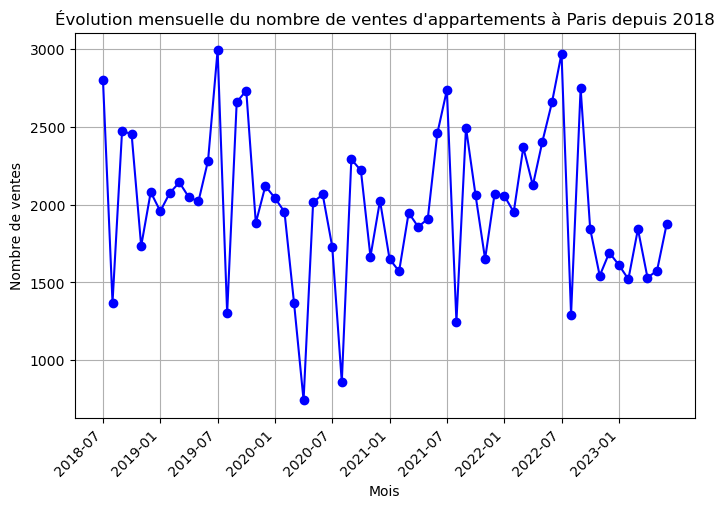

In [262]:
"""Evolution du nombre d'appartements vendus, à une fréquence annuelle ou mensuelle"""

from Visualisation import evolution_nombre

evolution_nombre(dvf, "Année")
evolution_nombre(dvf, "Mois")

**Remarques :**

Ces évolutions temporelles permettent de mettre en évidence plusieurs choses.

- D'abord, il y a une augmentation du prix moyen de l'immobilier en région parisienne ces dernières années. Cela justifie que nous nous restreigons aux ventes qui ont eu lieu entre 2021 et 2023, afin de se placer sur une période où le prix semble assez homogène.

- Il semble qu'il y a moins de ventes pour les années 2018 et 2023, mais cela vient du fait que ces fichiers sont tronqués (l'année 2023 ne contient que le premier trimestre, et 2018 que le dernier).

- Il semble y avoir une dimension cyclique dans le prix et dans le nombre des ventes. Ainsi, il y a toujours beaucoup moins de ventes durant le mois d'août, mais un pic au printemps (pour le nombre et le prix). Cela justifierait l'ajout d'une dimension temporelle dans notre modélisation.

- On peut remarquer l'effet de la crise sanitaire : il y a eu une chute du nombre de ventes pour les mois de mars et d'avril 2020.

On se restreint donc à la période 2021-2023 à partir de maintenant.

In [263]:
"""Restriction à la période 2021-2023"""
dvf = dvf.loc[(dvf['date_mutation'].dt.year >= 2021) & (dvf['date_mutation'].dt.year <= 2023)]

### **2) Visualisation graphique**

Ici, on représente le prix moyen (brut, et au m^2) des appartements vendus, selon l'arrondissement et le quartier parisien. Il s'agit de mettre en évidence que certains quartiers sont plus chers que d'autres, ce qui justifiera d'incorporer le quartier dans la modélisation.

In [264]:
"""Données administratives géographiques de paris intra muros"""

paris_arrondissement = gpd.read_file('2) Visualisation/Données_carto/paris_arrondissements.geojson')
paris_quartiers = gpd.read_file('2) Visualisation/Données_carto/paris_quartiers.geojson')
paris_quartiers = paris_quartiers[['c_quinsee', 'l_qu', 'geometry']]

In [266]:
"""Fonction qui trace le prix moyen du m^2 par arrondissement"""

def carte_prix_moyen_arrodissement(dvf):
    #dvf : geodataframe avec une colonne 'geometry'

    # on ne garde que les colonnes prix au m^2 et geometry
    dvf = dvf[['prix_au_m2_carrez', 'prix_au_m2_reel_bati', 'geometry']]  

    # on ajoute à chaque appartement les données administratives de son arrondissement
    dvf_geo = gpd.sjoin(dvf, paris_arrondissement, predicate = 'within')

    # regroupement selon les arrondissements et prix moyen au m2 carrez
    dvf_geo_group_carrez = (dvf_geo
      .groupby("INSEE_COG")
      .agg({"prix_au_m2_carrez": "mean"})
      .reset_index())

    # regroupement selon les arrondissements et prix moyen au m2 réel
    dvf_geo_group_reel = (dvf_geo
      .groupby("INSEE_COG")
      .agg({"prix_au_m2_reel_bati": "mean"})
      .reset_index())

    # on ajoute aux données administratives les prix moyens
    paris_arrondissement_count_carrez = paris_arrondissement.merge(
        dvf_geo_group_carrez
    ).to_crs(2154)

    paris_arrondissement_count_reel = paris_arrondissement.merge(
        dvf_geo_group_reel
    ).to_crs(2154)

    # Créer une figure avec deux sous-graphiques côte à côte
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Première carte (à gauche)
    paris_arrondissement_count_carrez.plot(ax=ax1, column="prix_au_m2_carrez", cmap="coolwarm", legend=True)
    ax1.set_title('Prix moyen du m^2 carrez - Carte 1')
    ax1.set_xticks([], [])
    ax1.set_yticks([], [])
    
    # Deuxième carte (à droite)
    paris_arrondissement_count_reel.plot(ax=ax2, column="prix_au_m2_reel_bati", cmap="coolwarm", legend=True)
    ax2.set_title('Prix moyen du m^2 reel bati - Carte 2')
    ax2.set_xticks([], [])
    ax2.set_yticks([], [])
    
    # Ajuster l'espacement entre les sous-graphiques
    plt.subplots_adjust(wspace=0.2)
    
    plt.show()

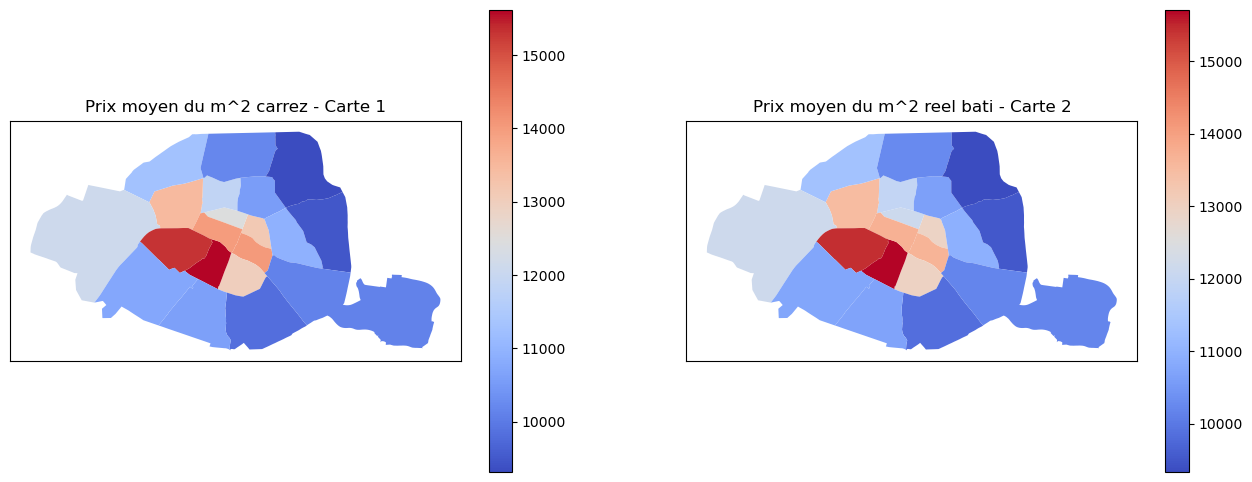

In [267]:
"""Application de la fonction"""

carte_prix_moyen_arrodissement(dvf)

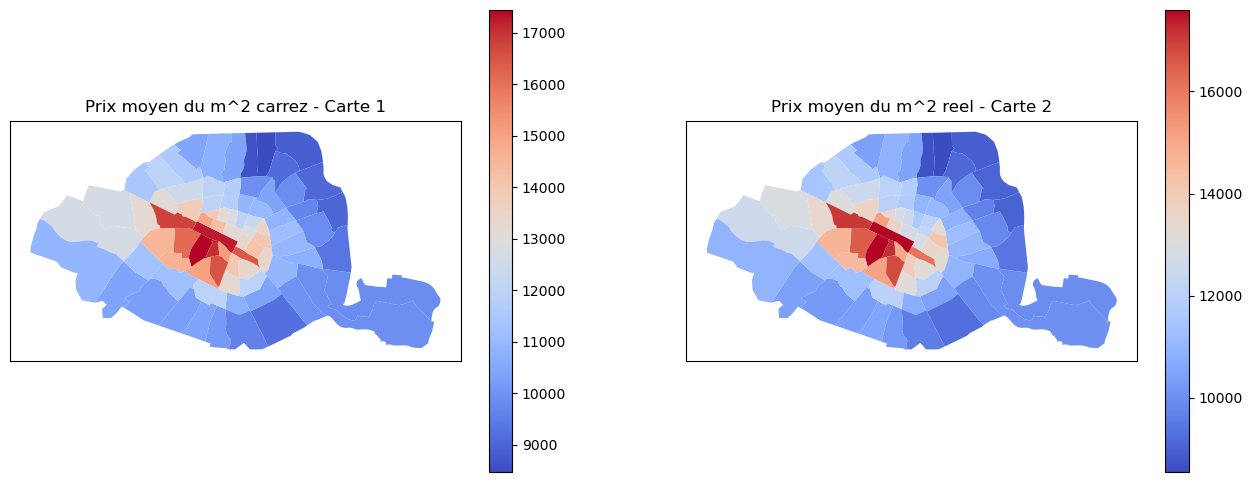

In [268]:
"""Carte du prix moyen par quartier"""

from Visualisation import carte_prix_moyen_quartier

carte_prix_moyen_quartier(dvf)

**Remarques :**

Ces cartes permettent de mettre en évidence un effet quartier sur le prix des appartements. Les quartiers les plus chers se trouvent au centre de Paris. En particulier, le quartier de Saint-Germain des Prés, dans le 6ème arrondissement, et les quartiers de l'Ile Saint-Louis et de Notre-Dame, sont parmi les plus chers. Les quartiers en bordure de Paris (notamment le 19ème et le 20ème) sont moins chers, à part le 16ème arrondissement.

## **III) Enrichissement des données**

Le but de cette partie est d'enrichir la base de données DVF avec des informations susceptibles d'influencer le prix de l'immobilier. Comme il faut que l'information varie d'un appartement à un autre, une manière naturelle de procéder est d'ajouter la distance minimale des appartements à plusieurs catégories de lieu d'intérêt.

Toutes les données utilisées ici sont disponible en open data, mais ont été enregistrées dans le dossier `3.0) Enrichissement données/Données` au format Geojson pour plus de facilité. Les sources exactes sont précisées au début de chaque partie.

Pour les lieux d'intérêt, nous retenons ici : 

- Les espaces verts parisiens, en opérant une distinction entre les grands espaces verts (Jardin des Plantes, Jardin des Tuileries, etc.) et les squares.
- Les meilleurs lycées, dont la liste des 100 premiers est récupérée par scrapping sur le site du Figaro.
- Les transports (stations de métro, de RER et TRAM)
- Les sites historiques (musées, monuments, églises)
- Les voies d'eau (en particulier la Seine)

Les codes des fonctions utilisées dans cette partie sont dans le fichier `Enrichissement.py`, on ne montrera la fonction qui calcule les distances minimales que pour le premier type de lieu d'intérêt, à savoir les parcs. La méthode est en effet toujours la même :

- Récupérer les données en open-data
- Affiner selon des critères spécifiques
- Utiliser la fonction `sjoin_nearest` de la biliothèque GeoPanda, qui compare les colonnes `geometry` de deux dataframes pour trouver automatiquement, dans notre cas, le lieu d'intérêt le plus proche pour chaque appartement, et qui calcule la distance minimale

### **1) Ajout des espaces verts**

Le but est de trouver l'espace vert le plus proche de chaque appartement, en différenciant selon le type d'espace vert.

*Source des données sur les espaces verts : https://opendata.paris.fr/explore/dataset/espaces_verts/information*

In [269]:
"""Lecture du fichier des parcs"""
emplacement_parcs = '3.0) Enrichissement données/Données/Espaces_verts_parisiens.geojson'
df_espaces_verts_brut = gpd.read_file(emplacement_parcs, low_memory=False, index_col=0)
df_espaces_verts_brut.head(2)

,nsq_espace_vert,nom_ev,type_ev,categorie,adresse_numero,adresse_complement,adresse_typevoie,adresse_libellevoie,adresse_codepostal,poly_area,...,id_division,id_atelier_horticole,ida3d_enb,site_villes,id_eqpt,competence,geom,url_plan,geom_x_y,geometry
0,10383.0,JARDINIERE DE LA RUE DUMERIL,Décorations sur la voie publique,Jardiniere,1.0,NaN,RUE,DUMERIL,75013,4.0,...,113.0,19.0,JDE7336,SV,7336,CA,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"POLYGON ((2.35752 48.83770, 2.35752 48.83769, ..."
1,363.0,SQUARE JEAN COCTEAU,Promenades ouvertes,Square,122.0,NaN,AVENUE,FELIX FAURE,75015,3295.0,...,115.0,29.0,57896,1318,3619,CA,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"POLYGON ((2.28064 48.83851, 2.28075 48.83842, ..."


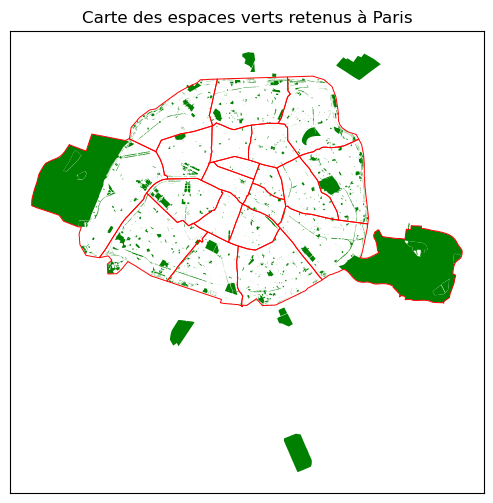

In [270]:
"""Visualisation des espaces verts sur une carte"""

fig, ax = plt.subplots(figsize=(8, 6))

base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "red", linewidth = 0.7)
df_espaces_verts_brut.plot(ax=ax, color='green')

plt.xticks([], [])
plt.yticks([], [])

plt.title('Carte des espaces verts retenus à Paris')

plt.show()

On voit qu'il y a plusieurs modifications à faire.

D'abord, il manque le Jardin des plantes, le Jardin des tuileries, et du Luxembourg. Cela provient du fait que le fichier de départ est celui de la voirie de Paris (qui ne s'occupe pas du Jardin du Luxebourg par exemple, car il dépend du Sénat). On va donc les rajouter manuellement, selon les coordonnées qu'on peut voir ci-dessous.

In [163]:
coord_jardin_du_luxembourg = [
    [48.848583, 2.332634],
    [48.849056, 2.338542],
    [48.847234, 2.340275],
    [48.844127, 2.338816],
    [48.844720, 2.332550]
]

coord_jardin_des_plantes = [
    [48.846779, 2.360882],
    [48.843693, 2.364841],
    [48.841292, 2.356097],
    [48.843813, 2.355056]
]

coord_jardin_des_tuileries = [
    [48.866346, 2.323663],
    [48.863713, 2.331903],
    [48.861017, 2.329972],
    [48.863854, 2.321604]
]

In [271]:
"""Ajout des 3 parcs manquants"""

from Enrichissement import ajout_3_parcs

df_espaces_verts_brut = ajout_3_parcs()

df_espaces_verts_brut.tail(3)

,nsq_espace_vert,nom_ev,type_ev,categorie,adresse_numero,adresse_complement,adresse_typevoie,adresse_libellevoie,adresse_codepostal,poly_area,...,id_division,id_atelier_horticole,ida3d_enb,site_villes,id_eqpt,competence,geom,url_plan,geom_x_y,geometry
2286,NaN,JARDIN DES PLANTES,NaN,Parc,NaN,NaN,NaN,NaN,75,221416.238529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((2.36088 48.84678, 2.36484 48.84369, ..."
2287,NaN,JARDIN DES TUILERIES,NaN,Parc,NaN,NaN,NaN,NaN,75,220233.048327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((2.32366 48.86635, 2.33190 48.86371, ..."
2288,NaN,JARDIN DU LUXEMBOURG,NaN,Parc,NaN,NaN,NaN,NaN,75,251125.065297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((2.33263 48.84858, 2.33854 48.84906, ..."


On distingue ensuite les grands parcs et les squares, en créant deux sous-dataframe `df_grands_parcs` et `df_squares`. Pour les parcs, comme pour les squares, on choisit une aire minimale afin de ne garder que les plus importants. On les représente ensuite sur une carte de Paris

In [272]:
"""On créée un premier dataframe df_grands_parcs"""

#on garde les espaces verts de plus de X m^2
df_grands_parcs = df_espaces_verts_brut.loc[df_espaces_verts_brut['poly_area']>50000]

#on ne garde que les parcs parisiens
df_grands_parcs = df_grands_parcs[df_grands_parcs['adresse_codepostal'].astype(str).str.startswith('75')]

#on gardes les types d'intérêt
df_grands_parcs = df_grands_parcs.loc[df_grands_parcs['categorie'].isin(['Jardin', 'Parc', 'Cimetière', 'Bois', 'Esplanade'])]

df_grands_parcs.shape

(31, 30)

In [273]:
"""On créée un dataframe df_squares contenant les squares"""

#on garde les squares
df_squares = df_espaces_verts_brut.loc[df_espaces_verts_brut['categorie'].isin(['Square'])].copy()

#on les réduit à leur centre
proj_lambert = 'EPSG:3942'
df_squares = df_squares.to_crs(proj_lambert)
df_squares['geometry'] = df_squares['geometry'].centroid
proj_wgs84 = 'EPSG:4326'
df_squares = df_squares.to_crs(proj_wgs84)

#on garde les X plus grands
df_squares = df_squares.nlargest(50, 'poly_area')

df_squares.shape

(50, 30)

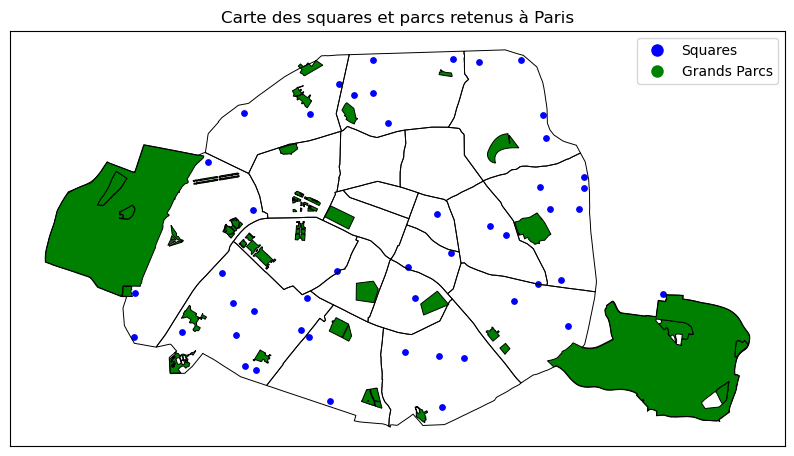

In [274]:
"""Visualisation des squares et des parcs sur une carte"""
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 8))

base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_squares.plot(ax=ax, color='blue', markersize=15, label='Squares')
df_grands_parcs.plot(ax=ax, color='green', alpha=1, edgecolor='black', linewidth=0.7, label='Grands parcs')

plt.xticks([], [])
plt.yticks([], [])

# Créez des objets de légende explicites
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Squares'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Grands Parcs')
]

# Ajoutez une légende en utilisant les objets de légende explicites
ax.legend(handles=legend_elements)

plt.title('Carte des squares et parcs retenus à Paris')

plt.show()

Maintenant, on définit les deux fonctions qui vont ajouter, pour chaque appartement du dataframe `dvf` le nom de l'espace vert (parc ou square) retenu le plus proche, et ainsi que la distance minimale (à vol d'oiseau).

In [275]:
"""Fonction qui merge les data set en trouvant le parc (polygone) le plus proche et enregistre la distance (en km)"""

def ajout_grands_parc(dvf, df_grands_parcs):

    #sélection des variables
    var_parcs = ['nom_ev', 'geometry']
    df_grands_parcs = df_grands_parcs[var_parcs].copy()
    
    #Passer en projection 2D
    proj_lambert = 'EPSG:3942'
    dvf = dvf.to_crs(proj_lambert)
    df_grands_parcs = df_grands_parcs.to_crs(proj_lambert)

    #jointure spatiale
    merged_nearest = gpd.sjoin_nearest(dvf, df_grands_parcs, how="left", max_distance=5000, distance_col="dist_min_grand_parc")

    #dist en km
    merged_nearest['dist_min_grand_parc'] = merged_nearest['dist_min_grand_parc']/1000

    #repasser en système de projection wgs 84
    dvf_avec_parc = merged_nearest.to_crs('EPSG:4326')

    #supprimer et renommer colonnes
    dvf_avec_parc = dvf_avec_parc.drop(['index_right'], axis=1)    
    dvf_avec_parc = dvf_avec_parc.rename(columns={'nom_ev': 'nom_grand_parc'})

    return dvf_avec_parc

In [276]:
"""Fonction qui merge les data set en trouvant le square (point) le plus proche et enregistre la distance (en km)"""

def ajout_squares(dvf, df_squares):
    
    #sélection des variables
    var_squares = ['nom_ev', 'geometry']
    df_squares = df_squares[var_squares].copy()
    
    #Passer en projection 2D
    proj_lambert = 'EPSG:3942'
    dvf = dvf.to_crs(proj_lambert)
    df_squares = df_squares.to_crs(proj_lambert)

    #jointure spatiale
    merged_nearest = gpd.sjoin_nearest(dvf, df_squares, how="left", max_distance=5000, distance_col="dist_min_square")

    #dist en km
    merged_nearest['dist_min_square'] = merged_nearest['dist_min_square']/1000

    #repasser en système de projection wgs 84
    dvf_avec_squares = merged_nearest.to_crs('EPSG:4326')

    #supprimer et renommer colonnes
    dvf_avec_squares = dvf_avec_squares.drop(['index_right'], axis=1)    
    dvf_avec_squares = dvf_avec_squares.rename(columns={'nom_ev': 'nom_square'})

    return dvf_avec_squares

In [277]:
"""Application des fonctions"""

dvf_avec_parcs = ajout_grands_parc(dvf, df_grands_parcs)

dvf_avec_ev = ajout_squares(dvf_avec_parcs, df_squares)

In [278]:
dvf_avec_ev.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,nom_arrondissement,num_arrondissement,nom_quartier,longitude,latitude,geometry,nom_grand_parc,dist_min_grand_parc,nom_square,dist_min_square
60122,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,Paris 8e Arrondissement,08,Europe,2.320982,48.876954,POINT (2.32098 48.87695),PARC MONCEAU,0.715347,SQUARE DES BATIGNOLLES,1.228584
60123,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,Paris 3e Arrondissement,03,Archives,2.367136,48.856147,POINT (2.36714 48.85615),JARDIN DES PLANTES,1.146792,SQUARE LOUIS XIII,0.131711


### **2) Ajout des transports**

Ici on ajoute les transports, en suivant la même procédure que pour les parcs. Commençons par charger les données, effectuer quelques modifications pour conserver seulement les stations de métro, de RER et de Tram, puis visualiser les stations retenues.

*Source des données de transport : https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/information/*

In [279]:
"""Lecture du fichier transports"""

emplacement = '3.0) Enrichissement données/Données/Transports_idf.geojson'
df_transport = gpd.read_file(emplacement, low_memory=False, index_col=0)
df_transport.head(2)

,geo_point_2d,id_gares,nom_gares,nom_so_gar,nom_su_gar,id_ref_zdc,nom_zdc,id_ref_zda,nom_zda,idrefliga,...,tertram,terval,exploitant,idf,principal,x,y,picto,nom_iv,geometry
0,"{'lon': 2.372103138402568, 'lat': 48.963755428...",643,Pierrefitte Stains,NaN,NaN,72787,Pierrefitte - Stains,43179,Pierrefitte - Stains,A01842,...,0,0,SNCF,1,0,654024.0938,6.873939e+06,"{'thumbnail': True, 'filename': 'RER_D.svg', '...",Pierrefitte Stains,POINT (2.37210 48.96376)
1,"{'lon': 2.312307716888593, 'lat': 48.780313795...",102,Bourg-la-Reine,NaN,NaN,70033,Bourg-la-Reine,43097,Bourg-la-Reine,A01857,...,0,0,RATP,1,0,649468.2085,6.853578e+06,"{'thumbnail': True, 'filename': 'RER_B.svg', '...",Bourg-la-Reine,POINT (2.31231 48.78031)


In [280]:
"""Modifications du fichier"""

var_interet = ['nom_gares', 'nom_so_gar', 'nom_su_gar', 'idrefligc', 'res_com', 'indice_lig', 'mode', 'tertrain', 'terrer',
       'termetro', 'tertram', 'terval', 'exploitant', 'idf', 'geometry']

df_transport = df_transport.loc[:, var_interet]

#création de sous dataframes selon le type de transport
df_metro = df_transport.loc[df_transport['mode']=='METRO']
df_rer = df_transport.loc[df_transport['mode']=='RER']
df_tram = df_transport.loc[df_transport['mode']=='TRAMWAY']

#réduction du df
df_transport = df_transport.loc[df_transport['mode'].isin(['METRO', 'RER', 'TRAMWAY'])]

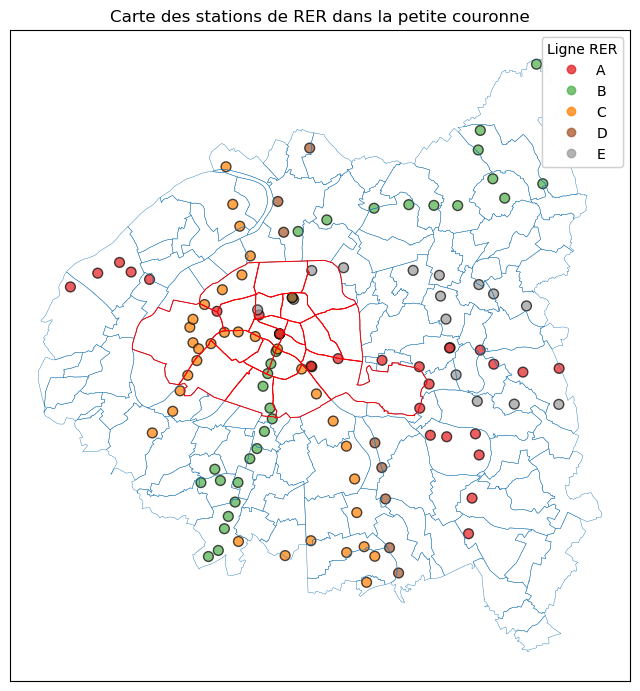

In [281]:
"""Visualisation des stations RER"""

from Enrichissement import plot_rer_stations

plot_rer_stations()

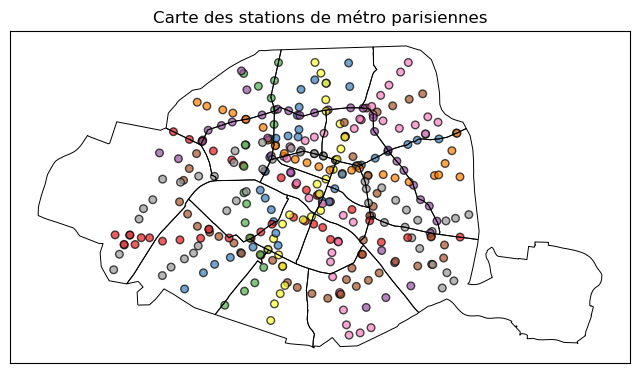

In [282]:
"""Visualisation des stations de métro"""

from Enrichissement import carte_metro

carte_metro()

Maintenant, on ajoute la station de transport la plus proche (ainsi que son nom, le numéro de la ligne, et la distance minimale), au fichier dvf.

In [283]:
from Enrichissement import ajout_stat_trans

dvf_avec_trans = ajout_stat_trans(dvf_avec_ev, df_transport)

In [284]:
dvf_avec_trans.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,longitude,latitude,geometry,nom_grand_parc,dist_min_grand_parc,nom_square,dist_min_square,nom_stat,num_ligne,dist_min_stat
60122,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,2.320982,48.876954,POINT (2.32098 48.87695),PARC MONCEAU,0.715347,SQUARE DES BATIGNOLLES,1.228584,Europe,3,0.224501
60123,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,2.367136,48.856147,POINT (2.36714 48.85615),JARDIN DES PLANTES,1.146792,SQUARE LOUIS XIII,0.131711,Chemin Vert,8,0.132209


### **3) Ajout des lycées**

Ici on ajoute la distance minimale aux meilleurs lycées parisiens. La localisation des lycées est obtenue en open data. La liste des noms des meilleurs lycées est obtenue par scrapping sur le classement du figaro, et elle a été enregistrée ici : `3.0) Enrichissement données/Données/liste_meilleurs_lycées.pkl` au cas où la structure du site changerait. Le code du scrapping est présenté ci-dessous (afficher la liste si nécessaire).

*Source des données des lycées : https://data.iledefrance.fr/explore/dataset/lycees-donnees-generales/export/*

In [178]:
import requests
from bs4 import BeautifulSoup

!pip install unidecode
from unidecode import unidecode

!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

import pickle

# URL du classement des lycées à Paris
url = 'https://classement-lycees.etudiant.lefigaro.fr/ville-paris+75056/'

# Récupérer le contenu HTML de la page
response = requests.get(url)
html_content = response.content

# Utiliser BeautifulSoup pour parser le HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Trouver les noms des lycées dans le classement
lycees_classement = [lycee.find('b').text.strip() for lycee in soup.find_all('td', class_='school')]

# Passer tous les noms en majuscule, retirer la partie 'LYCEE ' des noms
lycees_liste = [unidecode(lycee.replace('Lycée ', '').replace('LYCEE ', '').replace('-', '').replace(' ', '').upper()) for lycee in lycees_classement]

#changer l'écriture de Henri IV
for i in range(len(lycees_liste)):
    lycees_liste[i] = lycees_liste[i].replace('HENRI-IV', 'HENRI IV')

#afficher la liste
#lycees_liste

Maintenant, on lit le fichier des lycées localisés, on effectue quelques modifications.

On charge ensuite la liste des lycées parisiens, puis on utilise la fonction `has_similar_name` ci-dessous pour comparer la similitude de chaînes de caractères, afin de ne garder que les lycées qui sont dans la liste des meilleurs lcyées retenus. Enfin, on visualise les lycées.

In [289]:
"""Définition de la fonction de similitude de chaînes de caractères"""
def has_similar_name(name, lycees_liste, ratio):
    
    for element in lycees_liste:
        # Calculer le ratio de similarité
        similarity_ratio = fuzz.ratio(name, element)
        # Si le ratio est supérieur à une certaine valeur (par exemple, 80), on le considère comme une correspondance
        if similarity_ratio > ratio:
            return True
            
    return False

In [290]:
"""Lecture du fichier des lycées d'île de France"""

emplacement_lycées = '3.0) Enrichissement données/Données/Lycées_idf.geojson'
df_lycées_idf = gpd.read_file(emplacement_lycées, low_memory=False, index_col=0)

In [291]:
"""Restriction aux lycées parisiens et normalisation du nom de l'établissement"""

var_interet = ['code_academie', 'academie', 'dep',
       'nature_uai', 'patronyme', 'nom_etablissement', 'statut',
       'contrat_etablissement', 'adresse_postale', 'code_postal', 'code_insee', 'geometry']

df_lycées_idf = df_lycées_idf.loc[:,var_interet].copy()

df_lycées_paris = df_lycées_idf.loc[df_lycées_idf['dep']=='75'].copy()

#patronyme_modif pour faciliter le traitement par la suite
df_lycées_paris['patronyme_modif'] = df_lycées_paris['patronyme'].apply(lambda x: unidecode(x.replace(' ', '').replace('-', '')).upper())

In [292]:
"""Charger la liste des meilleurs lycées"""

emplacement_liste = '3.0) Enrichissement données/Données/liste_meilleurs_lycées.pkl'

with open(emplacement_liste, 'rb') as fichier:
    liste_meilleurs_lycées = pickle.load(fichier)[:15] #prendre les x meilleurs

In [293]:
"""Création du dataframe df_meilleurs_lycées_paris contenant seulement le nombre de lycées qu'on a fixé"""

# Appliquer la fonction pour créer une colonne de vérification de similarité
df_lycées_paris['similar_name'] = df_lycées_paris['patronyme_modif'].apply(lambda x: has_similar_name(x, liste_meilleurs_lycées, 77))

# Filtrer les données en fonction de la colonne de similarité
df_meilleurs_lycées_paris = df_lycées_paris[df_lycées_paris['similar_name'] | df_lycées_paris['patronyme_modif'].isin(liste_meilleurs_lycées)]

# Supprimer la colonne temporaire 'similar_name'
df_meilleurs_lycées_paris = df_meilleurs_lycées_paris.drop(columns=['similar_name'])

"""Vérification du nombre de lycées retenus"""
df_meilleurs_lycées_paris.shape

(14, 13)

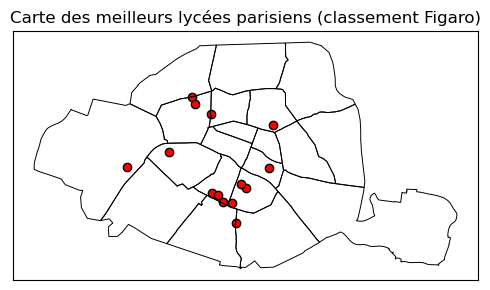

In [294]:
"""Visualisation des meilleurs lycées parisiens"""

fig, ax = plt.subplots(figsize=(6, 5))
paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7) #on ajout les arrondissements parisiens en rouge
df_meilleurs_lycées_paris.plot(ax=ax, color='red', alpha=1, edgecolor='black', linewidth=1) #on ajoute les lycées
#rien sur les axes
plt.xticks([], [])
plt.yticks([], [])
#titre
plt.title('Carte des meilleurs lycées parisiens (classement Figaro)')
plt.show()

Il y a bien une concentration des meilleurs lycées dans le 5ème arrondissement.

Maintenant, on calcule la distance minimale en appliquant une fonction similaire à celle utilisée jusqu'à présent.

In [295]:
"""Ajout des lycées au fichier dvf"""

from Enrichissement import ajout_meilleurs_lycées

dvf_avec_lycées = ajout_meilleurs_lycées(dvf_avec_trans, df_meilleurs_lycées_paris)

In [296]:
dvf_avec_lycées.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,geometry,nom_grand_parc,dist_min_grand_parc,nom_square,dist_min_square,nom_stat,num_ligne,dist_min_stat,nom_lycee,dist_min_lycee
60122,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,POINT (2.32098 48.87695),PARC MONCEAU,0.715347,SQUARE DES BATIGNOLLES,1.228584,Europe,3,0.224501,FÉNELON-SAINTE-MARIE-LA-PLAINE-MONCEAU,0.286341
60123,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,POINT (2.36714 48.85615),JARDIN DES PLANTES,1.146792,SQUARE LOUIS XIII,0.131711,Chemin Vert,8,0.132209,CHARLEMAGNE,0.536373


### **4) Ajout des des sites historiques**

On suit la même procédure que pour les lycées, mais cette fois pour ajouter les lieux historiques/touristiques. Comme le fichier initial contient un grand nombre de monuments, on va essayer de ne sélectionner que les plus emblématiques. La procédure est identique à celle utilisée pour les lycées. On récupère par scrapping les 50 monuments mentionnés sur un site touristique quelconque : https://parisjetaime.com/article/les-monuments-parisiens-un-patrimoine-exceptionnel-a024. Comme pour les lycées, la liste obtenue a été enregistrée dans le dossier `Projet-python-2A/3.0) Enrichissement données/Données` au cas où la structure du site changerait.

*Source des données des sites historiques : https://data.opendatasoft.com/explore/dataset/monuments-historiques-classes-ou-inscrits-en-ile-de-france-donnees-drac%40datailedefrance/export/?basemap=jawg.dark&location=14,48.84294,2.35215*

In [297]:
"""Lecture du fichier des sites historiques"""
emplacement = '3.0) Enrichissement données/Données/Monuments_historiques_idf.geojson'
df_monuments = gpd.read_file(emplacement, low_memory=False, index_col=0)

Pour les sites historiques (monuments), renseignés ici sous la forme de polygones, nous allons les réduire à des points pour réduire le temps de calcul. Il s'agit aussi de ne conserver que ceux de Paris intra-muros

In [298]:
"""Nettoyage"""

#restriction à Paris
df_monuments_paris = df_monuments.loc[df_monuments['dep']=='Paris']

#edifices publics et petits monuments
df_monuments_retenus = df_monuments_paris.loc[df_monuments_paris['type_archi'].isin(
    ['Edifice public', 'Petit monument', 'Edifice religieux'])
    ]

#Réduction à des points
proj_lambert = 'EPSG:3942'
df_monuments_retenus = df_monuments_retenus.to_crs(proj_lambert)
df_monuments_retenus['geometry'] = df_monuments_retenus['geometry'].centroid
proj_wgs84 = 'EPSG:4326'
df_monuments_retenus = df_monuments_retenus.to_crs(proj_wgs84)

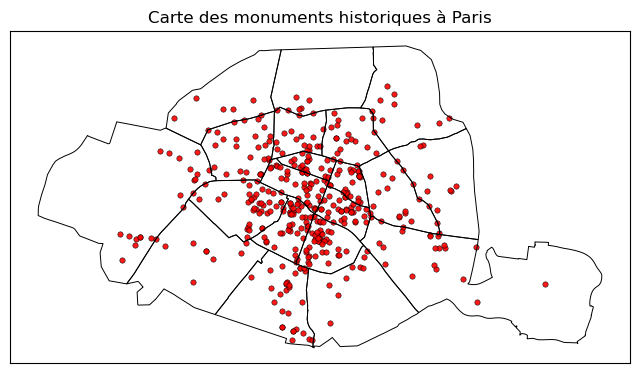

In [299]:
"""Première visualisation"""

fig, ax = plt.subplots(figsize=(8, 6))
base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_monuments_retenus.plot(ax=ax, color='red', alpha=0.9, markersize=15, edgecolor='black', linewidth=0.4)
plt.xticks([], [])
plt.yticks([], [])
plt.title('Carte des monuments historiques à Paris')
plt.show()

In [300]:
"""Scrapping pour récupérer la liste des monuments emblématiques"""

url = "https://parisjetaime.com/article/les-monuments-parisiens-un-patrimoine-exceptionnel-a024"

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
response = requests.get(url, headers=headers)

monuments_list = []

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')

    # Modifier le sélecteur CSS en fonction de la structure HTML du site
    monuments = soup.select('.layout_highlight_address_info')

    for monument in monuments:
        nom_du_monument = monument.text.strip()
        monuments_list.append(nom_du_monument)
else:
    print(f"Erreur {response.status_code} lors de la récupération de la page.")

#modification des la liste
monuments_list = [unidecode(monument.replace('-', '').replace(' ', '').upper()) for monument in monuments_list]

print(monuments_list)

['LATOUREIFFEL', 'MUSEEDULOUVRE', 'SAINTECHAPELLE', "MUSEED'ORSAY", 'FONDATIONLOUISVUITTON', 'PANTHEON', 'ARCDETRIOMPHE', 'MUSEEDUQUAIBRANLYJACQUESCHIRAC', 'INSTITUTDUMONDEARABE', 'MUSEERODINPARIS', 'CONCIERGERIE', 'CENTREPOMPIDOU', 'GRANDPALAIS', 'GRANDPALAISEPHEMERE', 'PETITPALAISMUSEEDESBEAUXARTSDELAVILLEDEPARIS', 'MUSEEDECLUNY-MUSEENATIONALDUMOYENAGE', 'CATHEDRALENOTREDAMEDEPARISETSONTRESOR', 'HOTELDEBETHUNESULLY', 'BASILIQUEDUSACRECOEURDEMONTMARTRE', 'AVENUEDESCHAMPSELYSEES', 'TOURSAINTJACQUES', 'HOTELDEVILLEDEPARIS', 'ILEDELACITE', 'GAREDUNORD', "GAREDEL'EST", "CIRQUED'HIVERBOUGLIONE", 'CATHEDRALEDELASAINTETRINITEEGLISEORTHODOXERUSSE', 'CENTREBOUDDHIQUEKAGYUDZONGGRANDEPAGODEDEVINCENNES', 'PLACEDELACONCORDE', 'TOURJEANSANSPEUR', 'ARENESDELUTECEETSQUARECAPITAN', 'PALAISDETOKYO', 'PASSAGEBRADY', 'OPERANATIONALDEPARISPALAISGARNIER', 'CIMETIEREDUPERELACHAISE', 'PARISMONTPARNASSETOPOFTHECITY']


In [191]:
"""Chargement de la liste en cas d'échec du scrapping"""
with open('3.0) Enrichissement données/Données/liste_principaux_monuments.pkl', 'rb') as file:
    monuments_list = pickle.load(file)

In [301]:
"""Restriction des données aux monuments principaux"""

#modifier la colonne contenant les noms
df_monuments_retenus['nom_modif'] = df_monuments_retenus['immeuble'].apply(lambda x: unidecode(x.replace(' ', '').replace('-', '').replace('Métropolitain', '')
                                                                                            .replace('station', '').replace(',','').upper()))

# Appliquer la fonction pour créer une colonne de vérification de similarité
df_monuments_retenus['similar_name'] = df_monuments_retenus['nom_modif'].apply(lambda x: has_similar_name(x, monuments_list,56))

# Filtrer les données en fonction de la colonne de similarité
df_monuments_principaux = df_monuments_retenus[df_monuments_retenus['similar_name'] | df_monuments_retenus['nom_modif'].isin(monuments_list)]

# Supprimer la colonne temporaire 'similar_name'
df_monuments_principaux = df_monuments_principaux.drop(columns=['similar_name'])

"""Vérification du nombre de monumnets retenus"""
df_monuments_principaux.shape

(50, 22)

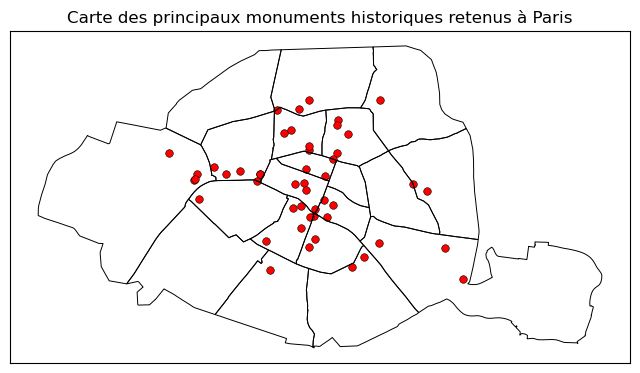

In [302]:
"""Deuxième visualisation"""

fig, ax = plt.subplots(figsize=(8, 6))
base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_monuments_principaux.plot(ax=ax, color='red', alpha=1, markersize=30, edgecolor='black', linewidth=0.4)
plt.xticks([], [])
plt.yticks([], [])
plt.title('Carte des principaux monuments historiques retenus à Paris')
plt.show()

In [303]:
"""Ajout au fichier dvf"""

from Enrichissement import ajout_sites_histo

dvf_avec_sites_histo = ajout_sites_histo(dvf_avec_lycées, df_monuments_principaux)

dvf_avec_sites_histo.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,dist_min_grand_parc,nom_square,dist_min_square,nom_stat,num_ligne,dist_min_stat,nom_lycee,dist_min_lycee,nom_site_histo,dist_min_site_histo
60122,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,0.715347,SQUARE DES BATIGNOLLES,1.228584,Europe,3,0.224501,FÉNELON-SAINTE-MARIE-LA-PLAINE-MONCEAU,0.286341,Eglise de la Trinité,0.770349
60123,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,1.146792,SQUARE LOUIS XIII,0.131711,Chemin Vert,8,0.132209,CHARLEMAGNE,0.536373,Hôtel de Ville,1.078004


### **5) Ajout des des voies d'eau**

On enrichit encore nos données, en ajoutant la distance au voies d'eau (Seine et canal Saint-Martin), pour essayer de capter l'effet "vue sur la Seine" dans le prix de l'immobilier.

*Source des données : https://opendata.paris.fr/explore/dataset/plan-de-voirie-voies-deau/export/?disjunctive.num_pave&disjunctive.lib_level&disjunctive.lib_classe*

In [308]:
"""Lecture du fichier des voies d'eau"""
emplacement = '3.0) Enrichissement données/Données/Voies_eau_paris.geojson'
df_eau = gpd.read_file(emplacement, low_memory=False, index_col=0)

"""Rassemblement des voies d'eau en un seul polygone"""
union_polygon = df_eau.unary_union

"""Créer un nouveau DataFrame GeoPandas avec le polygone résultant"""
df_eau = gpd.GeoDataFrame(geometry=[union_polygon], crs=df_eau.crs)

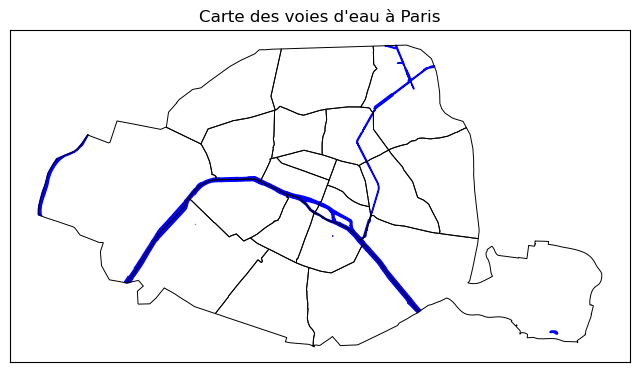

In [309]:
"""Visualisation des voies d'eau sur une carte"""

fig, ax = plt.subplots(figsize=(8, 6))
base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_eau.plot(ax=ax, color='blue', alpha=1, edgecolor='blue', linewidth=1)
plt.xticks([], [])
plt.yticks([], [])
plt.title("Carte des voies d'eau à Paris")
plt.show()

In [310]:
"""Ajout au fichier dvf"""

from Enrichissement import ajout_voies_eau

dvf_avec_eau = ajout_voies_eau(dvf_avec_sites_histo, df_eau)

dvf_avec_eau.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,nom_square,dist_min_square,nom_stat,num_ligne,dist_min_stat,nom_lycee,dist_min_lycee,nom_site_histo,dist_min_site_histo,dist_min_voie_eau
60122,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,SQUARE DES BATIGNOLLES,1.228584,Europe,3,0.224501,FÉNELON-SAINTE-MARIE-LA-PLAINE-MONCEAU,0.286341,Eglise de la Trinité,0.770349,1.418265
60123,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,SQUARE LOUIS XIII,0.131711,Chemin Vert,8,0.132209,CHARLEMAGNE,0.536373,Hôtel de Ville,1.078004,0.229360


### **6) Ajout de la distance au centre**

On finalise l'enrichissement de nos données, en ajoutant la distance au centre de Paris (représenté par un point arbitraire situé au nord de l'Île de la Cité). En effet, la ville de Paris (c'est à dire tous les lieux d'intérêts ajoutés jusque-là) est très centralisée : il y a moins de sites historiques par exemple en bordure de Paris, ce qui se reflète dans le prix des quartiers observé plus haut. L'ajout d'une variable `dist_min_centre_paris` pourra donc servir de bonne variable de contrôle.

In [311]:
centre_paris = [2.343678767984111, 48.85602158061093] 

In [312]:
centre_paris_point = Point(centre_paris)
centre_paris_gdf = gpd.GeoDataFrame(geometry=[centre_paris_point], crs='EPSG:4326')

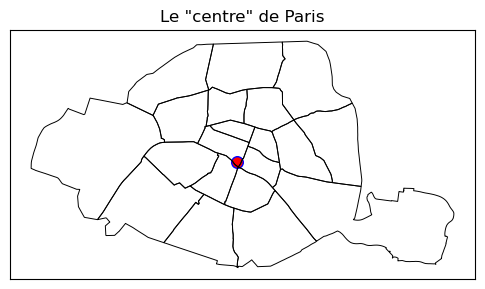

In [313]:
"""Visualisation du centre sur une carte"""

fig, ax = plt.subplots(figsize=(6, 4))
base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
centre_paris_gdf.plot(ax=ax, color='red', alpha=1, edgecolor='blue', markersize=70, linewidth=1)
plt.xticks([], [])
plt.yticks([], [])
plt.title('Le "centre" de Paris')
plt.show()

In [475]:
"""Ajout au fichier dvf"""

from Enrichissement import ajout_centre_paris

dvf_avec_dist_centre = ajout_centre_paris(dvf_avec_eau, centre_paris_gdf)

dvf_avec_dist_centre = dvf_avec_dist_centre.dropna(subset=['dist_min_paris_centre'])

dvf_avec_dist_centre.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,dist_min_square,nom_stat,num_ligne,dist_min_stat,nom_lycee,dist_min_lycee,nom_site_histo,dist_min_site_histo,dist_min_voie_eau,dist_min_paris_centre
60122,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,1.228584,Europe,3,0.224501,FÉNELON-SAINTE-MARIE-LA-PLAINE-MONCEAU,0.286341,Eglise de la Trinité,0.770349,1.418265,2.883285
60123,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,0.131711,Chemin Vert,8,0.132209,CHARLEMAGNE,0.536373,Hôtel de Ville,1.078004,0.229360,1.734097


## **IV) Modélisation**

Dans cette partie, le but sera de prédire au mieux le prix de l'immobilier, d'abord dans une approche plus "économétrique" (régression simple, utilisant l'effet fixe des quartiers), puis dans une approche plus "prédiction et sélection de variables" avec les méthodes LASSO et RIDGE.

Dans toute cette partie, on aura besoin de l'hypothèse que les observations (lignes de notre dataframe) sont iid, donc en particulier qu'aucun individu (ici, les appartements), n'apparaît deux fois (et donc, a été vendu deux fois). C'est une hypothèse raisonnable étant donnée la fenêtre de temps (2021-2023) considérée.

### **1) Observation et discrétisation des variables**

Ici, on va d'abord observer la distribution des distances qui ont été ajoutées au dataframe, puis on étudiera les choix de discrétisation pour envisager un effet non linéaire de certaines variables, et on observera les corrélations.

In [476]:
dvf_enrichi = dvf_avec_dist_centre.copy()

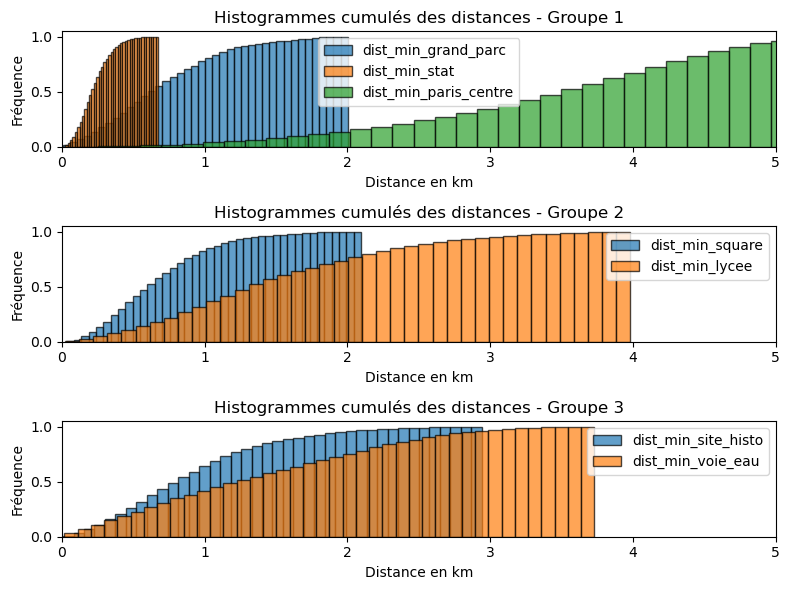

In [477]:
"""Distribution des distances"""

liste_var_dist = ['dist_min_grand_parc', 'dist_min_square', 'dist_min_site_histo', 
                  'dist_min_stat', 'dist_min_lycee', 'dist_min_voie_eau', 'dist_min_paris_centre']

# Initialiser une plage commune pour l'axe x
x_range = (0, 5)  # Ajustez selon vos besoins

# Créer une figure avec 3 sous-plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

# Boucle pour créer les histogrammes
for i, variable in enumerate(liste_var_dist):
    row = i % 3

    # Créer un histogramme de l'effectif cumulé
    axes[row].hist(dvf_enrichi[variable], bins=40, edgecolor='black', alpha=0.7, density=True, cumulative=True, label=variable)

    # Ajouter des étiquettes et un titre
    axes[row].set_xlabel('Distance en km')
    axes[row].set_ylabel('Fréquence')
    axes[row].set_title(f'Histogrammes cumulés des distances - Groupe {row + 1}')
    axes[row].set_xlim(x_range)
    axes[row].legend()

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher les histogrammes
plt.show()

On peut voir que tous les appartements parisiens sont à moins de 800m environ d'une station de métro, et à moins de deux kilomètres d'un grand espace vert. Cela nous sera utile pour définir les seuils de discrétisation des variables de distance.  

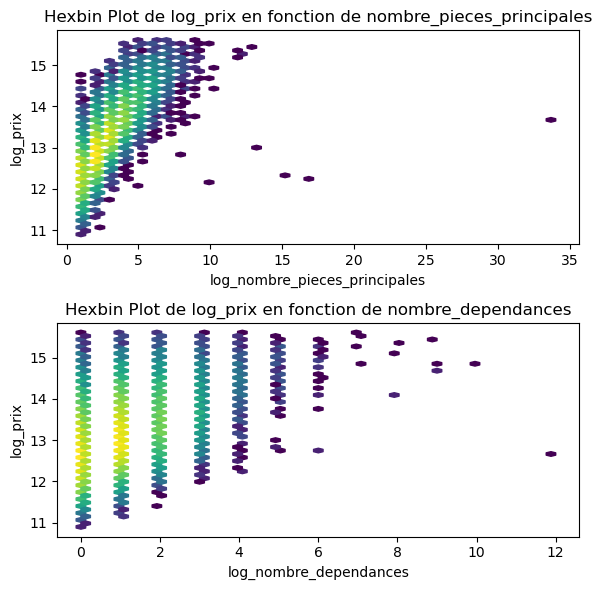

In [478]:
"""Observation des variables discrètes"""

# Liste des variables explicatives
variables_explicatives = ['nombre_pieces_principales', 'nombre_dependances']

# Créer des sous-plots pour chaque variable explicative
fig, axes = plt.subplots(nrows=len(variables_explicatives), ncols=1, figsize=(6, 3 * len(variables_explicatives)))

# Boucle pour créer les graphiques hexbin
for i, variable_explicative in enumerate(variables_explicatives):
    axes[i].hexbin(dvf_enrichi[variable_explicative], dvf_enrichi['log_prix'], gridsize=50, cmap='viridis', bins='log')
    axes[i].set_xlabel(f'log_{variable_explicative}')
    axes[i].set_ylabel('log_prix')
    axes[i].set_title(f'Hexbin Plot de log_prix en fonction de {variable_explicative}')

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher les graphiques hexbin
plt.show()

On voit qu'il y a un effet non linéaire : pour discrétiser ces variables, on va crééer des indicatrices pour les appartements ayant 1, 2, 3, 4, 5+ pièces principales (on ne met pas d'indicatrice pour ceux ayant 1 pièce principale, afin d'éviter la colinéarité). De même pour les dépendances.

In [479]:
"""Discrétisation du nombre de pièces et de dépendances"""

#on rassemble les valeurs supérieures à 5 pour le nombre de pièces
dvf_enrichi['nombre_pieces_principales'] = dvf_enrichi['nombre_pieces_principales'].apply(lambda x: min(x, 5))

# Créez les indicatrices pour les valeurs 1, 2, 3, 4, et une seule indicatrice pour les valeurs 5 et plus
dvf_enrichi = pd.get_dummies(dvf_enrichi, columns=['nombre_pieces_principales'], prefix='pieces', drop_first=True, dtype=int)
dvf_enrichi = dvf_enrichi.rename(columns={'pieces_5.0': 'pieces_5.0+'})

#on rassemble les valeurs supérieures à 5 pour le nombre de dépendances
dvf_enrichi['nombre_dependances'] = dvf_enrichi['nombre_dependances'].apply(lambda x: min(x, 5))

# Créez les indicatrices pour les valeurs 1, 2, 3, 4, et une seule indicatrice pour les valeurs 5 et plus
dvf_enrichi = pd.get_dummies(dvf_enrichi, columns=['nombre_dependances'], prefix='dependances', drop_first=True, dtype=int)
dvf_enrichi = dvf_enrichi.rename(columns={'dependances_5.0': 'dependances_5.0+'})

In [480]:
dvf_enrichi.head(2)

,id_mutation,date_mutation,prix,log_prix,surface_reelle_bati,surface_carrez,prix_au_m2_carrez,prix_au_m2_reel_bati,adresse_numero,adresse_nom_voie,...,dist_min_paris_centre,pieces_2.0,pieces_3.0,pieces_4.0,pieces_5.0+,dependances_1.0,dependances_2.0,dependances_3.0,dependances_4.0,dependances_5.0+
60122,2021-1680087,2021-01-05,1480000.0,14.207553,111.0,116.01,12758.0,13333.0,4.0,RUE DE LA BIENFAISANCE,...,2.883285,0,0,0,1,0,0,1,0,0
60123,2021-1680092,2021-01-07,300000.0,12.611538,23.0,19.39,15472.0,13043.0,313.0,RUE DES TOURNELLES,...,1.734097,0,0,0,0,0,0,0,0,0


Observons maintenant les variables continues (surface, et distance aux lieux d'intérêt) dont on prend le logarithme.

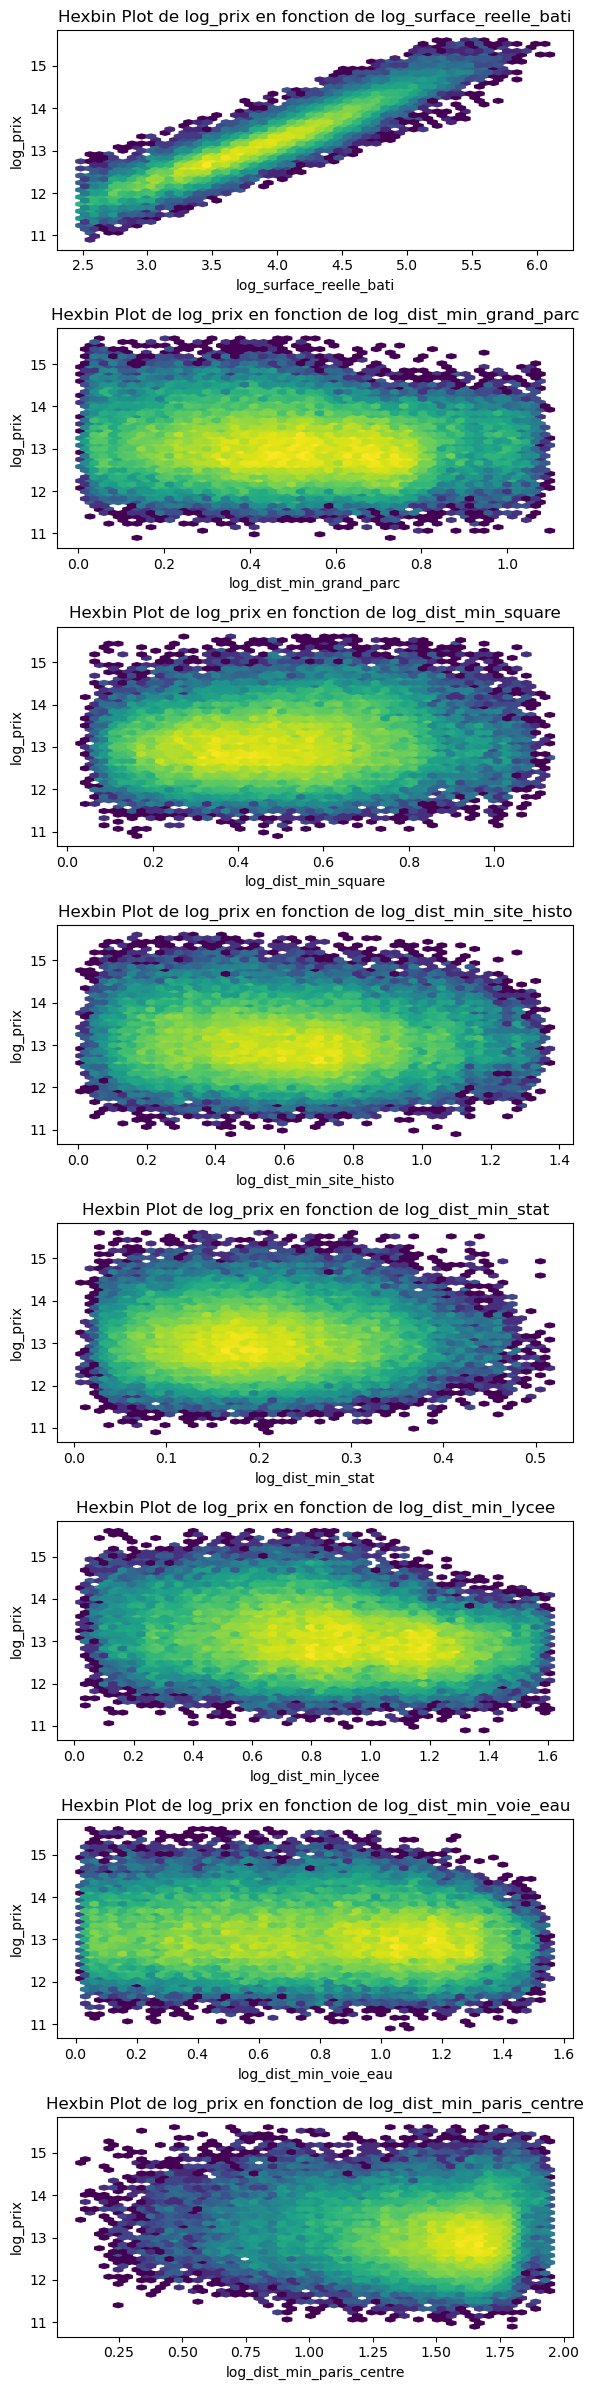

In [481]:
# Liste des variables explicatives
variables_explicatives = ['surface_reelle_bati', 'dist_min_grand_parc', 'dist_min_square', 'dist_min_site_histo', 
                           'dist_min_stat', 'dist_min_lycee', 'dist_min_voie_eau', 'dist_min_paris_centre']

# Appliquer le logarithme aux variables explicatives
for variable_explicative in variables_explicatives:
    dvf_enrichi[f'log_{variable_explicative}'] = np.log1p(dvf_enrichi[variable_explicative])

# Créer des sous-plots pour chaque variable explicative
fig, axes = plt.subplots(nrows=len(variables_explicatives), ncols=1, figsize=(6, 3 * len(variables_explicatives)))

# Boucle pour créer les graphiques hexbin
for i, variable_explicative in enumerate(variables_explicatives):
    axes[i].hexbin(dvf_enrichi[f'log_{variable_explicative}'], dvf_enrichi['log_prix'], gridsize=50, cmap='viridis', bins='log')
    axes[i].set_xlabel(f'log_{variable_explicative}')
    axes[i].set_ylabel('log_prix')
    axes[i].set_title(f'Hexbin Plot de log_prix en fonction de log_{variable_explicative}')

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher les graphiques hexbin
plt.show()

On peut donc avoir une bonne confiance dans l'effet linéaire du log de la variable de surface, qui avait donc au départ un effet non linéaire comme on pouvait s'en douter. Pour toutes nos variables de distance, c'est plus difficile à dire pour l'instant, il faut travailler un peu plus : il n'y aura sans doute un effet notable que pour un seuil de distance assez faible, c'est ce qu'on veut mettre en évidence maintenant. On va faire les variables une à une.

In [482]:
"""Fonction qui trace le prix moyen des appartements, selon une distance spécifiée et selon les bornes qu'on renseigne"""

def plot_prix_moyen_par_interval(dvf_enrichi, variable_distance, bornes, labels):
    # Définir la taille de la figure
    plt.figure(figsize=(6,4))

    # Ajouter une colonne 'variable_distance_interval' pour représenter les intervalles
    dvf_enrichi[f'{variable_distance}_interval'] = pd.cut(dvf_enrichi[variable_distance], bins=bornes, labels=labels)

    # Convertir la colonne en catégorie pour inclure les étiquettes manquantes
    dvf_enrichi[f'{variable_distance}_interval'] = pd.Categorical(dvf_enrichi[f'{variable_distance}_interval'], categories=labels, ordered=True)

    # Calculer le prix moyen global
    prix_moyen_global = dvf_enrichi['prix'].mean()

    # Calculer le prix moyen pour chaque intervalle
    prix_moyen_par_interval = dvf_enrichi.groupby(f'{variable_distance}_interval', observed=False)['prix'].mean()

    # Créer un histogramme avec une largeur de barre ajustée
    plt.bar(prix_moyen_par_interval.index, prix_moyen_par_interval, width=0.6, label='Prix moyen par intervalle')

    # Ajouter une barre pour le prix moyen global
    plt.axhline(y=prix_moyen_global, color='red', linestyle='--', label='Prix moyen global')

    # Ajouter des étiquettes et un titre
    plt.xlabel(f'Plage de {variable_distance}')
    plt.ylabel('Prix moyen')
    plt.title(f'Prix moyen en fonction de {variable_distance}')
    plt.legend(loc='lower right')  # Ajouter la légende

    # Afficher l'histogramme
    plt.show()

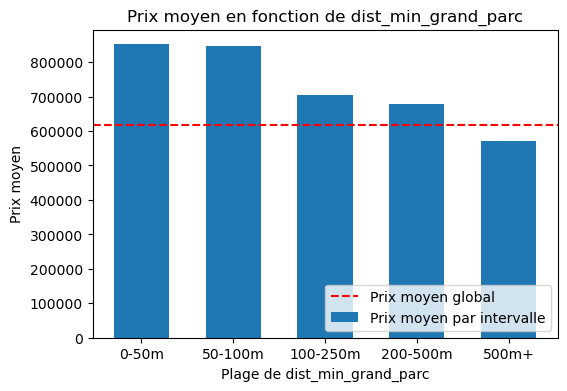

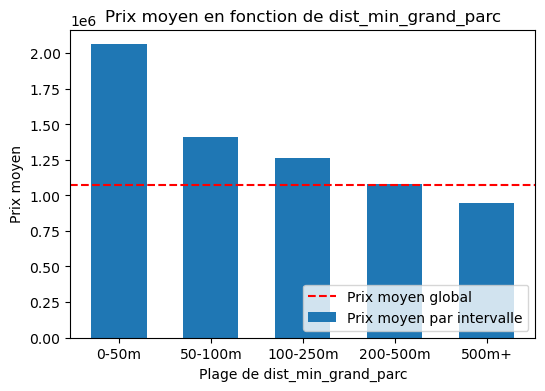

In [483]:
"""Observation des parcs"""

bornes_parc = [0.0, 0.05, 0.1, 0.25, 0.5, 10]
labels_parc = ['0-50m', '50-100m', '100-250m', '200-500m', '500m+']

#dans tout Paris
plot_prix_moyen_par_interval(dvf_enrichi, 'dist_min_grand_parc', bornes_parc, labels_parc)

#en contrôlant selon l'arrondissement
plot_prix_moyen_par_interval(dvf_enrichi.loc[dvf_enrichi['num_arrondissement']=='06'].copy(),
                             'dist_min_grand_parc', bornes_parc, labels_parc)

Pour les grands parcs, on va garder ces bornes, en enlevant l'intervalle 500m+ (toujours pour ne pas avoir de colinéarité).

In [484]:
#discrétisation de la distance en utilisant la colonne dist_min_grand_parc_interval créée dans la fonction précédente

dvf_enrichi = pd.get_dummies(dvf_enrichi, columns=['dist_min_grand_parc_interval'], prefix='dist_min_parc', dtype=int)

#on retire la valeur 500m+
dvf_enrichi_disc_parc = dvf_enrichi.drop('dist_min_parc_500m+', axis=1, errors='ignore')

In [485]:
dvf_enrichi_disc_parc.head()

,id_mutation,date_mutation,prix,log_prix,surface_reelle_bati,surface_carrez,prix_au_m2_carrez,prix_au_m2_reel_bati,adresse_numero,adresse_nom_voie,...,log_dist_min_square,log_dist_min_site_histo,log_dist_min_stat,log_dist_min_lycee,log_dist_min_voie_eau,log_dist_min_paris_centre,dist_min_parc_0-50m,dist_min_parc_50-100m,dist_min_parc_100-250m,dist_min_parc_200-500m
60122,2021-1680087,2021-01-05,1480000.0,14.207553,111.0,116.01,12758.0,13333.0,4.0,RUE DE LA BIENFAISANCE,...,0.801366,0.571176,0.202533,0.251802,0.883050,1.356681,0,0,0,0
60123,2021-1680092,2021-01-07,300000.0,12.611538,23.0,19.39,15472.0,13043.0,313.0,RUE DES TOURNELLES,...,0.123731,0.731408,0.124171,0.429424,0.206493,1.005801,0,0,0,0
60124,2021-1680094,2021-01-06,1000000.0,13.815511,60.0,66.13,15122.0,16667.0,16.0,RUE DU PARC ROYAL,...,0.376504,0.607256,0.318307,0.469726,0.486235,0.905726,0,0,0,0
60125,2021-1680096,2021-01-08,1525559.0,14.237871,91.0,83.16,18345.0,16764.0,22.0,RUE JEAN GOUJON,...,0.543245,0.075553,0.313040,0.536686,0.209237,1.381234,0,0,0,1
60126,2021-1680100,2021-01-13,375000.0,12.834681,20.0,25.06,14964.0,18750.0,159.0,RUE DU TEMPLE,...,0.114149,0.550220,0.180956,0.547215,0.555856,0.910854,0,0,0,0


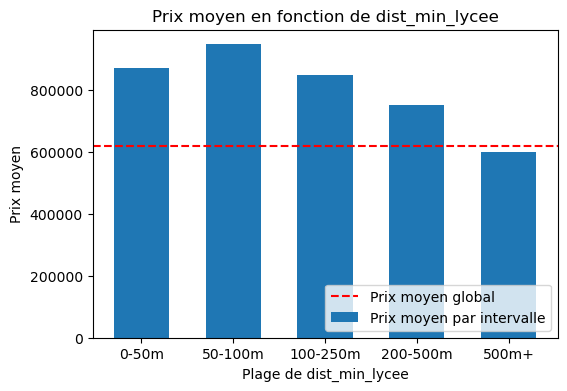

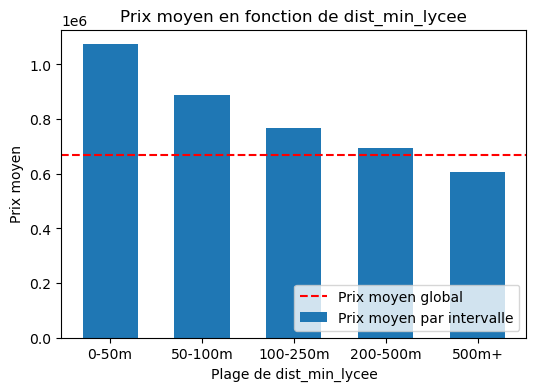

In [486]:
"""Observation des lycées"""
bornes_lycee = [0.0, 0.05, 0.1, 0.25, 0.5, 10]
labels_lycee = ['0-50m', '50-100m', '100-250m', '200-500m', '500m+']

#dans tout Paris
plot_prix_moyen_par_interval(dvf_enrichi_disc_parc, 'dist_min_lycee', bornes_lycee, labels_lycee)

#en contrôlant selon l'arrondissement
plot_prix_moyen_par_interval(dvf_enrichi_disc_parc.loc[dvf_enrichi_disc_parc['num_arrondissement']=='05'].copy(),
                             'dist_min_lycee', bornes_lycee, labels_lycee)

In [487]:
"""discrétisation de la distance en utilisant la colonne dist_min_lycee_interval créée dans la fonction précédente"""

dvf_enrichi_disc_parc = pd.get_dummies(dvf_enrichi_disc_parc, columns=['dist_min_lycee_interval'], prefix='dist_min_lycee', dtype=int)

#on retire la valeur 500m+
dvf_enrichi_disc_lycees = dvf_enrichi_disc_parc.drop('dist_min_lycee_500m+', axis=1, errors='ignore')

On va garder ce choix de bornes, qui semble pertinent, pour toutes les variables. Il est toujours possible de l'observer pour les variables de distance restantes en spécifiant le nom de la variable dans les fonction précédentes.

In [488]:
"""Discrétisation des autres variables de distance"""

var_restantes = ['dist_min_voie_eau', 'dist_min_square', 'dist_min_stat', 'dist_min_site_histo']

bornes = [0.0, 0.05, 0.1, 0.25, 0.5, 10]
labels = ['0-50m', '50-100m', '100-250m', '200-500m', '500m+']

for variable_distance in var_restantes:
    # Créez la colonne d'intervalles
    dvf_enrichi_disc_lycees[f'{variable_distance}_interval'] = pd.cut(dvf_enrichi_disc_lycees[variable_distance], bins=bornes, labels=labels)

    # Créez les indicatrices directement au DataFrame d'origine
    dvf_enrichi_disc_lycees = pd.get_dummies(dvf_enrichi_disc_lycees, columns=[f'{variable_distance}_interval'], prefix=f'{variable_distance}_dist', dtype=int)

    # Supprimez la colonne spécifique dist_500m+ pour chaque variable
    colonne_specifique = f'{variable_distance}_dist_500m+'
    dvf_enrichi_disc_lycees = dvf_enrichi_disc_lycees.drop(colonne_specifique, axis=1, errors='ignore')


In [489]:
dvf_enrichi_disc = dvf_enrichi_disc_lycees.copy()

La dernière étape est d'ajouter les indicatrices de l'arrondissement, en retirant l'indicatrice de l'arrondissement médian en termes de prix moyen, puis d'observer la corrélation des variables.

In [490]:
#arrondissement médian
prix_moyen_arr = dvf_enrichi_disc.groupby('num_arrondissement')['prix'].mean().reset_index()
prix_moyen_arr = prix_moyen_arr.sort_values(by='prix', ascending=True)
arr_median_index = len(prix_moyen_arr) // 2
arr_median = prix_moyen_arr.iloc[arr_median_index]
print(arr_median)

num_arrondissement               17
prix                  666174.408013
Name: 16, dtype: object


In [491]:
#indicatrices des arrondissements
dvf_enrichi_disc = pd.get_dummies(dvf_enrichi_disc, columns=['num_arrondissement'], prefix='arr', dtype=int)
dvf_enrichi_disc = dvf_enrichi_disc.drop('arr_17', axis=1, errors='ignore')

In [492]:
#quartier médian
prix_moyen_quartier = dvf_enrichi_disc.groupby('nom_quartier')['prix'].mean().reset_index()
prix_moyen_quartier = prix_moyen_quartier.sort_values(by='prix', ascending=True)
quartier_median_index = len(prix_moyen_quartier) // 2
quartier_median = prix_moyen_quartier.iloc[quartier_median_index]
print(quartier_median)

nom_quartier         Grenelle
prix            605582.566901
Name: 28, dtype: object


In [493]:
#indicatrices des quartiers
dvf_enrichi_disc = pd.get_dummies(dvf_enrichi_disc, columns=['nom_quartier'], prefix='quartier', dtype=int)
dvf_enrichi_disc = dvf_enrichi_disc.drop("Grenelle", axis=1, errors='ignore')

On observe maintenant la corrélation des variables.

In [494]:
var_base = ['prix', 'surface_reelle_bati', 'surface_carrez', 'nombre_pieces_principales', 'nombre_dependances']

var_base2 = ['prix', 'surface_reelle_bati']

var_indic = ['dist_min_parc_0-50m', 'dist_min_parc_50-100m', 'dist_min_parc_100-250m', 'dist_min_parc_200-500m', 
             'dist_min_lycee_0-50m', 'dist_min_lycee_50-100m', 'dist_min_lycee_100-250m', 'dist_min_lycee_200-500m', 
             'dist_min_voie_eau_dist_0-50m', 'dist_min_voie_eau_dist_50-100m', 'dist_min_voie_eau_dist_100-250m', 'dist_min_voie_eau_dist_200-500m', 
             'dist_min_square_dist_0-50m', 'dist_min_square_dist_50-100m', 'dist_min_square_dist_100-250m', 'dist_min_square_dist_200-500m', 
             'dist_min_stat_dist_0-50m', 'dist_min_stat_dist_50-100m', 'dist_min_stat_dist_100-250m', 'dist_min_stat_dist_200-500m', 
             'dist_min_site_histo_dist_0-50m', 'dist_min_site_histo_dist_50-100m', 'dist_min_site_histo_dist_100-250m', 
             'dist_min_site_histo_dist_200-500m']

var_dist = ['dist_min_stat', 'dist_min_lycee', 'dist_min_site_histo',
       'dist_min_voie_eau', 'dist_min_paris_centre']

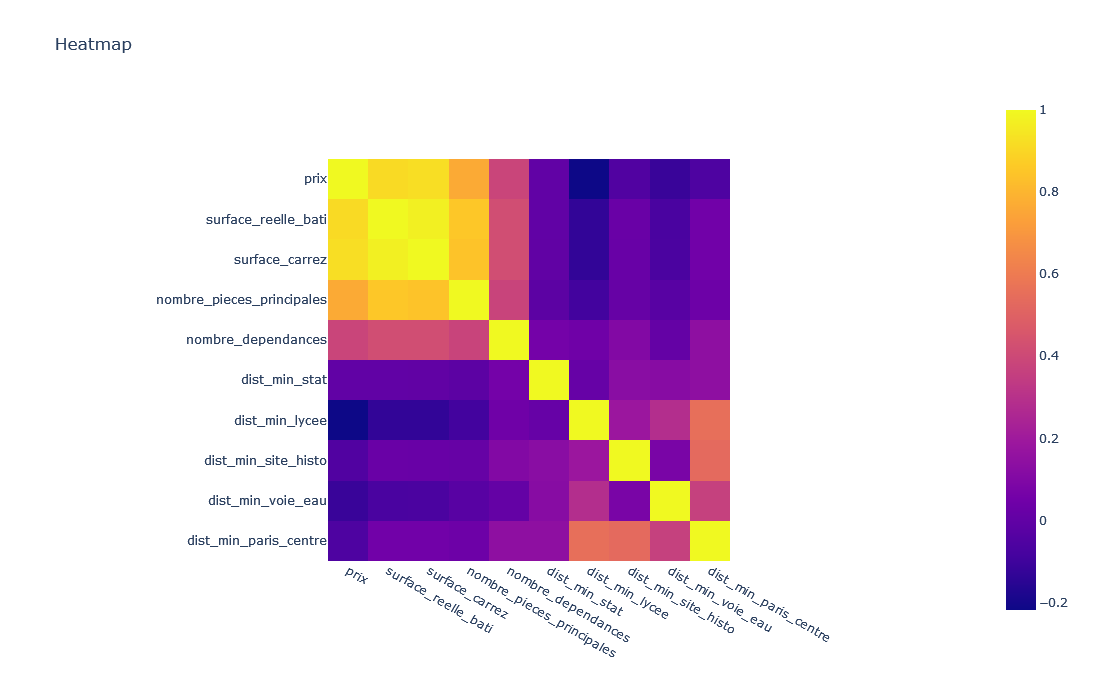

In [495]:
import plotly.express as px

dvf_corr = dvf_avec_dist_centre.copy()
dvf_corr = dvf_test[var_base+var_dist]

fig = px.imshow(dvf_corr.corr(), title='Heatmap',  width=700, height=700)
fig.show()

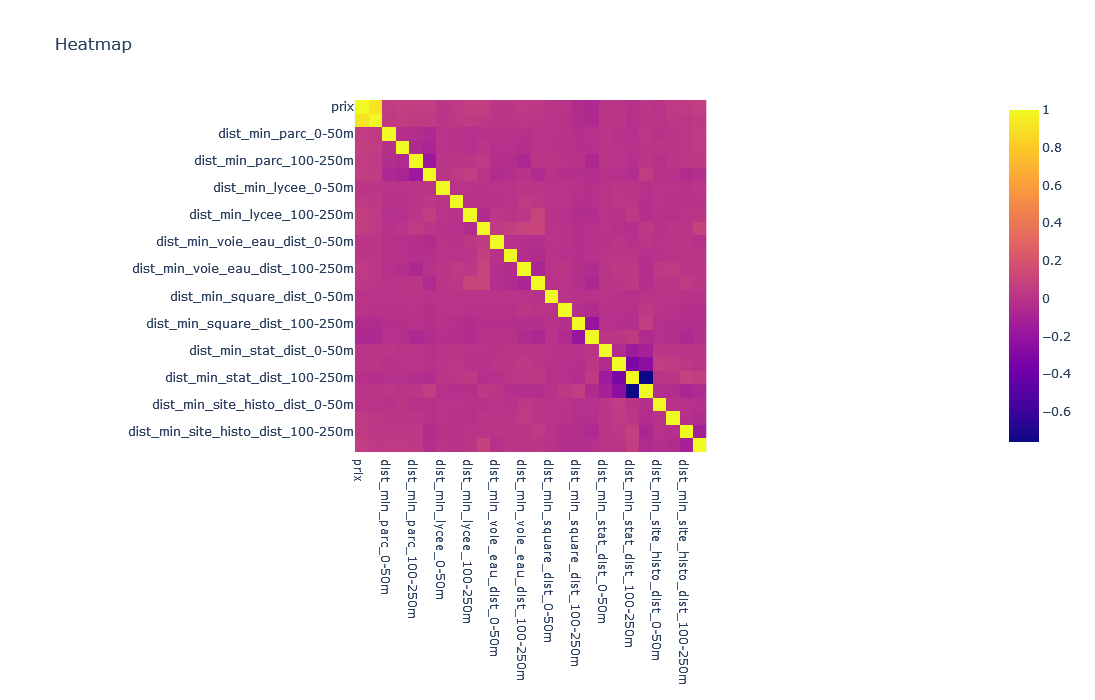

In [496]:
dvf_corr = dvf_enrichi_disc.copy()
dvf_corr = dvf_enrichi_disc[var_base2+var_indic]

fig = px.imshow(dvf_corr.corr(), title='Heatmap',  width=700, height=700)
fig.show()

Ainsi, avant la discrétisation, on observait une corrélation négative du prix avec les variables de distance. Après discrétisation, on récupère des corrélations légèrement positives, pour la plupart des lieux d'intérêt.

### **2) Approche économétrique : régression simple avec et sans effets fixes géographiques**

On va maintenant procéder à quelques régressions simples. Ici, l'apport principal sera l'ajout d'un effet fixe des quartiers/arrondissements, dont les indicatrices serviront de variables de contrôle. 

En effet, il y a une concentration des lieux d'intérêts dans le centre de Paris. Dès lors, pour les lieux d'intérêts situés dans le centre comme les lycées, on pourrait trouver un coefficient très fort, mais causé par le rapprochement du centre, plutôt que par la proximité aux lycées. L'ajout d'un effet fixe géographique devrait permettre d'éviter cela.

In [502]:
dvf_reg_eco = dvf_enrichi_disc.copy()

In [503]:
var_base = ['log_surface_reelle_bati', 'pieces_2.0', 'pieces_3.0', 'pieces_4.0', 'pieces_5.0+',
            'dependances_1.0','dependances_2.0', 'dependances_3.0', 'dependances_4.0', 'dependances_5.0+']

var_dist = ['dist_min_grand_parc', 'dist_min_square', 'dist_min_stat', 'dist_min_lycee', 'dist_min_site_histo', 'dist_min_voie_eau']

var_dist_disc = ['dist_min_parc_0-50m', 'dist_min_parc_50-100m', 'dist_min_parc_100-250m', 'dist_min_parc_200-500m', 'dist_min_lycee_0-50m', 
            'dist_min_lycee_50-100m', 'dist_min_lycee_100-250m', 'dist_min_lycee_200-500m', 'dist_min_voie_eau_dist_0-50m', 
            'dist_min_voie_eau_dist_50-100m', 'dist_min_voie_eau_dist_100-250m', 'dist_min_voie_eau_dist_200-500m', 
            'dist_min_square_dist_0-50m', 'dist_min_square_dist_50-100m', 'dist_min_square_dist_100-250m', 'dist_min_square_dist_200-500m', 
            'dist_min_stat_dist_0-50m', 'dist_min_stat_dist_50-100m', 'dist_min_stat_dist_100-250m', 'dist_min_stat_dist_200-500m', 
            'dist_min_site_histo_dist_0-50m', 'dist_min_site_histo_dist_50-100m', 'dist_min_site_histo_dist_100-250m', 
            'dist_min_site_histo_dist_200-500m']

In [511]:
var_ind_arr = ['arr_01', 'arr_02', 'arr_03', 'arr_04', 'arr_06', 'arr_05', 'arr_07', 'arr_08', 'arr_09', 
               'arr_10', 'arr_11', 'arr_12', 'arr_13', 'arr_14', 'arr_15', 'arr_16', 'arr_18', 'arr_19', 'arr_20']

var_ind_quartier = ['quartier_Amérique', 'quartier_Archives', 'quartier_Arsenal', 'quartier_Arts-et-Métiers', 'quartier_Auteuil', 
                    'quartier_Batignolles', 'quartier_Bel-Air', 'quartier_Belleville', 'quartier_Bercy', 'quartier_Bonne-Nouvelle', 
                    'quartier_Chaillot', 'quartier_Champs-Elysées', 'quartier_Charonne', "quartier_Chaussée-d'Antin", 'quartier_Clignancourt', 
                    'quartier_Combat', 'quartier_Croulebarbe', 'quartier_Ecole-Militaire', 'quartier_Enfants-Rouges', 'quartier_Epinettes', 
                    'quartier_Europe', 'quartier_Faubourg-Montmartre', 'quartier_Faubourg-du-Roule', 'quartier_Folie-Méricourt', 'quartier_Gaillon', 
                    'quartier_Gare', "quartier_Goutte-d'Or", 'quartier_Grandes-Carrières', 'quartier_Grenelle', 'quartier_Gros-Caillou', 
                    'quartier_Halles', 'quartier_Hôpital-Saint-Louis', 'quartier_Invalides', 'quartier_Jardin-des-Plantes', 'quartier_Javel', 
                    'quartier_La Chapelle', 'quartier_Madeleine', 'quartier_Mail', 'quartier_Maison-Blanche', 'quartier_Monnaie', 
                    'quartier_Montparnasse', 'quartier_Muette', 'quartier_Necker', 'quartier_Notre-Dame', 'quartier_Notre-Dame-des-Champs', 
                    'quartier_Odéon', 'quartier_Palais-Royal', 'quartier_Parc-de-Montsouris', 'quartier_Petit-Montrouge', 'quartier_Picpus', 
                    'quartier_Place-Vendôme', 'quartier_Plaine de Monceaux', 'quartier_Plaisance', 'quartier_Pont-de-Flandre', 
                    'quartier_Porte-Dauphine', 'quartier_Porte-Saint-Denis', 'quartier_Porte-Saint-Martin', 'quartier_Père-Lachaise', 
                    'quartier_Quinze-Vingts', 'quartier_Rochechouart', 'quartier_Roquette', 'quartier_Saint-Ambroise', 'quartier_Saint-Fargeau', 
                    'quartier_Saint-Georges', 'quartier_Saint-Germain-des-Prés', "quartier_Saint-Germain-l'Auxerrois", 'quartier_Saint-Gervais', 
                    'quartier_Saint-Lambert', 'quartier_Saint-Merri', "quartier_Saint-Thomas-d'Aquin", 'quartier_Saint-Victor', 
                    'quartier_Saint-Vincent-de-Paul', 'quartier_Sainte-Avoie', 'quartier_Sainte-Marguerite', 'quartier_Salpêtrière', 
                    'quartier_Sorbonne', 'quartier_Ternes', 'quartier_Val-de-Grace', 'quartier_Villette', 'quartier_Vivienne']

In [505]:
def regression_lineaire_multivariable(dvf, variable_a_expliquer, variables_explicatives):
    
    # Séparer la variable dépendante et les variables indépendantes
    y = dvf[variable_a_expliquer]
    X = dvf[variables_explicatives]

    # Ajouter une constante 
    X = sm.add_constant(X)

    # Initialiser le modèle de régression linéaire avec des estimateurs de variance robustes
    model = sm.OLS(y, X).fit(cov_type='HC3')

    # Afficher les résultats de la régression
    print(model.summary())


In [448]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import os

#### **a) Première régression : la surface**

In [506]:
"""Première régression avec uniquement la surface"""
regression_lineaire_multivariable(dvf_reg_eco, 'log_prix', 'log_surface_reelle_bati')

                            OLS Regression Results                            
Dep. Variable:               log_prix   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 3.285e+05
Date:                Tue, 26 Dec 2023   Prob (F-statistic):               0.00
Time:                        09:48:10   Log-Likelihood:                 179.44
No. Observations:               58390   AIC:                            -354.9
Df Residuals:                   58388   BIC:                            -336.9
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

- On voit qu'on a déjà un R^2 excellent avec seulement la variable de surface (on pouvait l'anticiper avec le plot qu'on avait fait dans la partie précédente).
Cela posera un problème dans l'approche prédiction, comme on le verra.
- Exemple d'intreprétation du coefficient :
  Une augmentation de 1% de la surface de l'appartement augmente le prix, en moyenne et toutes choses égales par ailleurs, de 1.07%. Ce coefficient est statistiquement significatif.

#### **b) Deuxième régression : variables de base et distances non discrétisées**

In [507]:
"""Deuxième régression avec les variables de base"""

regression_lineaire_multivariable(dvf_reg_eco, 'log_prix', var_base+var_dist)

                            OLS Regression Results                            
Dep. Variable:               log_prix   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 2.594e+04
Date:                Tue, 26 Dec 2023   Prob (F-statistic):               0.00
Time:                        09:48:12   Log-Likelihood:                 5948.4
No. Observations:               58390   AIC:                        -1.186e+04
Df Residuals:                   58373   BIC:                        -1.171e+04
Df Model:                          16                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

- Le R^2 augmente un peu (ce qui est normal puisqu'on ajoute des variables, mais il était déjà très haut).
- Ici, il y a un effet négatif (statistiquement significatif) pour quasiment toutes les variables de distance, ce qui est paradoxal. Pour y remédier, on va déjà utiliser la discrétisation.

#### **c) Troisème régression : variables de base et distances discrétisées**

In [508]:
"""Troisème régression avec les variables de base et les variables de distance discrétisées"""

regression_lineaire_multivariable(dvf_reg_eco, 'log_prix', var_base+var_dist_disc)

                            OLS Regression Results                            
Dep. Variable:               log_prix   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                 1.091e+04
Date:                Tue, 26 Dec 2023   Prob (F-statistic):               0.00
Time:                        09:48:21   Log-Likelihood:                 2710.0
No. Observations:               58390   AIC:                            -5350.
Df Residuals:                   58355   BIC:                            -5036.
Df Model:                          34                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

- On retrouve des effets positifs (donc plus cohérents) et quasiment toujours statistiquement significatifs, pour toutes nos variables de distance.
- En particulier, l'effet semble très fort pour les lycées et les sites historiques.
  Exemple de lecture :
  Pour un appartement parisien, passer de 500m+ à moins de 50m d'un des sites historiques retenus ici, augmente le prix, en moyenne et toutes choses égales par ailleurs, de 10.3%.
  De même, se rapprocher à moins de 50m d'un grand lycée parisien, augmente le prix, en moyenne et toutes choses égales par ailleurs, de presque 16%.
- Pour contrôler ces effets, on utilise d'abord la distance au centre.

#### **d) Quatrième régression : variables de base et distance discrétisées, avec contrôle selon l'arrondissement, et la distance au centre**

In [509]:
regression_lineaire_multivariable(dvf_reg_eco, 'log_prix', var_base+['dist_min_paris_centre']+var_dist_disc)

                            OLS Regression Results                            
Dep. Variable:               log_prix   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 1.131e+04
Date:                Tue, 26 Dec 2023   Prob (F-statistic):               0.00
Time:                        09:48:26   Log-Likelihood:                 4747.9
No. Observations:               58390   AIC:                            -9424.
Df Residuals:                   58354   BIC:                            -9101.
Df Model:                          35                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

- Le contrôle par la distance au centre de Paris a l'air de fonctionner : on trouve un coefficient négatif et statistiquement significatif pour la variable `dist_min_paris_centre`, ce qui signifie que le prix baisse en s'éloignant du centre (ce qui est l'effet attendu).
- Les coefficients qui étaient très élevés (pour les lycées et les sites touristiques) se sont atténués, car ces lieux d'intérêt sont concentrés dans le centre de Paris.
  Par exemple, le coefficient de `dist_min_site_histo_dist_50-100m` est passé de 0.14 à 0.47.
- On perd la significativité statistique des indicatrices de grande proximité (moins de 50m), pour la plupart des variables de distance.

In [512]:
regression_lineaire_multivariable(dvf_reg_eco, 'log_prix', var_base+var_dist_disc+var_ind_arr)

                            OLS Regression Results                            
Dep. Variable:               log_prix   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     8916.
Date:                Tue, 26 Dec 2023   Prob (F-statistic):               0.00
Time:                        09:53:35   Log-Likelihood:                 8795.2
No. Observations:               58390   AIC:                        -1.748e+04
Df Residuals:                   58336   BIC:                        -1.700e+04
Df Model:                          53                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

- En contrôlant par les arrondissements, on obtient des résultats similaires. On trouve que les quartiers centraux ont un coefficients positif et très élevé, tandis que les quartiers périphériques ont un coefficient négatif.
- Exemple d'interprétation :
  Pour un appartement parisien, passer du 17ème arrondissement au 1er arrondissement augmente le prix, en moyenne et toutes choses égales par ailleurs, de 14.8%.
- La distance aux stations de métro n'est pas très significative et on trouve un effet un peu contradictoire. Il faudrait sans doute être plus fin dans notre discrétisation, ou bien ajouter une dimension qualitative, car le maillage de transport en région parisienne est très efficace.

### **3) Approche orientée prédiction : régression LASSO, RIDGE**

**Rappel :**

La régression LASSO (Least Absolute Shrinkage and Selection Operator) et la régression Ridge sont deux techniques de régression régularisée utilisées pour éviter le surajustement et traiter le problème de multicolinéarité.

- **Pénalité L1 pour LASSO :**
  - Utilise une pénalité L1 (somme des valeurs absolues des coefficients multipliée par un paramètre d'hyperparamètre $\alpha$).
    
  - La pénalité L1 force certains coefficients à devenir exactement égaux à zéro, réalisant ainsi une sélection de variables.

    
- **Pénalité L2 pour Ridge :**
  - Utilise une pénalité L2 (somme des carrés des coefficients multipliée par un paramètre d'hyperparamètre $\alpha$).
    
  - La pénalité L2 a tendance à réduire les coefficients vers zéro sans les annuler complètement, répartissant la contribution des variables de manière plus équilibrée.

**Problème :**

Le modèle actuel présente un $R^2$ élevé en utilisant uniquement la variable de surface. Dès lors, il faudra définir un $\alpha$, en particulier en LASSO, pour conserver plus d'une seule variable. Mais un $\alpha$ très faible rend la régression LASSO de plus en plus similaire à une régression simple, limitant ainsi son intérêt dans ce contexte.

#### **3.1) Préprocessing**

On commence par préparer les données en les normalisant et en séparant les ensembles d'entraînement et de validation de nos modèles.

In [539]:
dvf_reg_lasso = dvf_enrichi_disc.copy()

In [540]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, mean_absolute_percentage_error

In [541]:
"""Définition des ensembles de test et d'entrainement"""

X = dvf_reg_lasso[var_base+var_dist_disc+var_ind_arr]
y = dvf_reg_lasso['log_prix']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

Pour la normalisation, on utilise `RobustScaler`, qui est insensible aux outliers. En notant IQR l'écart interquartile (Q3 -Q1), on a la formule suivante : 

$$ X_{scaled}=\frac{X - médiane}{IQR} $$

In [542]:
"""Normalisation des données et ajout d'une constante"""

scaler=RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

#### **3.2) Méthode LASSO**

On va choisir un alpha assez faible (au-delà de 0.1, seule la variable de surface est conservée).

In [543]:
def regression_lasso(X_train, y_train, X_test, y_test, variables_explicatives, alpha=0.1):

    # Initialiser le modèle de régression LASSO sur l'ensemble d'entraînement
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Afficher les coefficients
    coefs = pd.DataFrame({'Coefficients': model.coef_, 'Variable': ['const'] + variables_explicatives})
    coefs.sort_values(by='Coefficients', ascending=True, inplace=True)

    # Afficher un graphique de barres horizontal pour l'ensemble d'entraînement
    plt.figure(figsize=(8, 10))
    plt.barh(coefs['Variable'], coefs['Coefficients'], color='royalblue')
    plt.axvline(x=0, color='1')
    plt.title(f'LASSO Model Coefficients (alpha={alpha}) - Training Set')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Variable')
    plt.grid(True)
    plt.show()

    # Afficher différentes métriques
    print("____________________________________________________")
    print(f'model score R² on training data: {model.score(X_train, y_train)}')
    print(f'model score R_2 on testing data: {model.score(X_test, y_test)}')  
    print("__________________________________________________________________")
    print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
    print(f"Explained Variance Score: {explained_variance_score(y_test, y_pred)}")

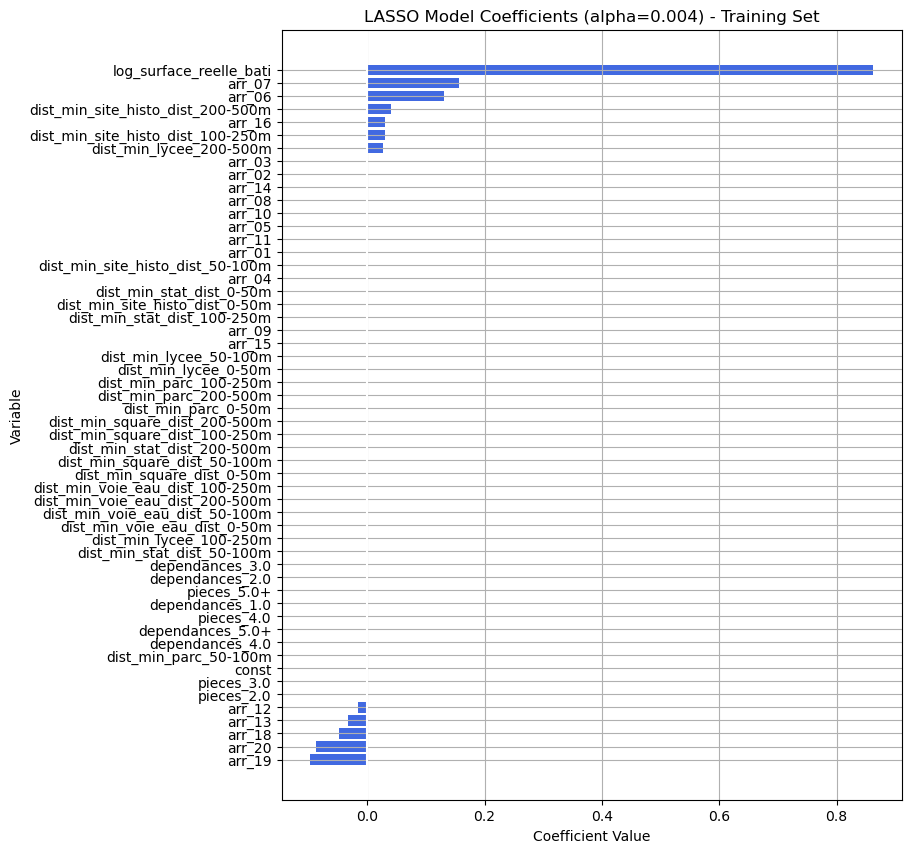

____________________________________________________
model score R² on training data: 0.8950906850462175
model score R_2 on testing data: 0.8952014952916164
__________________________________________________________________
Mean Absolute Percentage Error (MAPE): 0.012641827830882989
Mean Absolute Error (MAE): 0.16483070141803388
Mean Squared Error (MSE): 0.049040396421135744
Explained Variance Score: 0.8952107240418925


In [544]:
regression_lasso(X_train, y_train, X_test, y_test, var_base+var_dist_disc+var_ind_arr, alpha=0.004)

**Interprétation :**
Comme on pouvait s'y attendre, on a de bons résultats du modèle. Voici une brève interprétation des métriques de performance fournis :

- Score R² sur les données d'entraînement : 0.8951
        Le coefficient de détermination (R²) mesure la proportion de la variance de la variable dépendante expliquée par le modèle. Un score de 0.8951 indique que votre modèle explique environ 89.51% de la variance dans les données d'entraînement.

- Score R² sur les données de test : 0.8945
        Le score R² sur les données de test est très proche de celui sur les données d'entraînement (0.8945), ce qui suggère que votre modèle généralise bien sur de nouvelles données, évitant ainsi le surajustement.

- Mean Absolute Percentage Error (MAPE) : 0.0128
        Le MAPE mesure l'erreur moyenne en pourcentage entre les valeurs prédites et les valeurs réelles. Un MAPE de 0.0128 suggère que les prédictions de votre modèle ont une précision moyenne de 98.72%.

- Mean Absolute Error (MAE) : 0.1670
        Le MAE mesure l'erreur moyenne absolue entre les valeurs prédites et les valeurs réelles. Un MAE de 0.1670 indique en moyenne une erreur de 0.1670 unité dans vos prédictions.

- Mean Squared Error (MSE) : 0.0503
        Le MSE mesure l'erreur quadratique moyenne entre les valeurs prédites et les valeurs réelles. Un MSE de 0.0503 montre une moyenne quadratique de l'erreur de 0.0503 unité dans vos prédictions.

- Explained Variance Score : 0.8945
        Le score de variance expliquée mesure la proportion de la variance totale de la variable dépendante qui est expliquée par le modèle. Un score de 0.8945 est cohérent avec le R² et suggère une bonne capacité du modèle à expliquer la variance.


Après la surface, les **variables retenues** par le LASSO sont donc (pour un aplha de 0.004) : le fait d'appartenir aux arrondissements les plus chers (le 6ème et le 7ème) ou les moins chers (20ème, 19ème, etc), mais aussi la proximité aux sites historiques, et aux grands lycées parisiens. Etrangement, le nombre de pièces n'apparaît pas, alors que les coefficients de la régression étaient très importants : cela vient sans doute du fait que ce sont des variables très corrélées à la surface.

#### **3.2) Méthode Ridge**

In [247]:
from sklearn.linear_model import Ridge

def regression_ridge(X_train, y_train, X_test, y_test, variables_explicatives, alpha=0.01):

    # Initialiser le modèle de régression Ridge sur l'ensemble d'entraînement
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Afficher les coefficients
    coefs = pd.DataFrame({'Coefficients': model.coef_, 'Variable': ['const'] + variables_explicatives})
    coefs.sort_values(by='Coefficients', ascending=True, inplace=True)

    # Afficher un graphique de barres horizontal pour l'ensemble d'entraînement
    plt.figure(figsize=(8, 10))
    plt.barh(coefs['Variable'], coefs['Coefficients'], color='royalblue')
    plt.axvline(x=0, color='1')
    plt.title(f'Ridge Model Coefficients (alpha={alpha}) - Training Set')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Variable')
    plt.grid(True)
    plt.show()

    # Afficher différentes métriques
    print("____________________________________________________")
    print(f'model score R² on training data: {model.score(X_train, y_train)}')
    print(f'model score R² on testing data: {model.score(X_test, y_test)}')  
    print("__________________________________________________________________")
    print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
    print(f"Explained Variance Score: {explained_variance_score(y_test, y_pred)}")


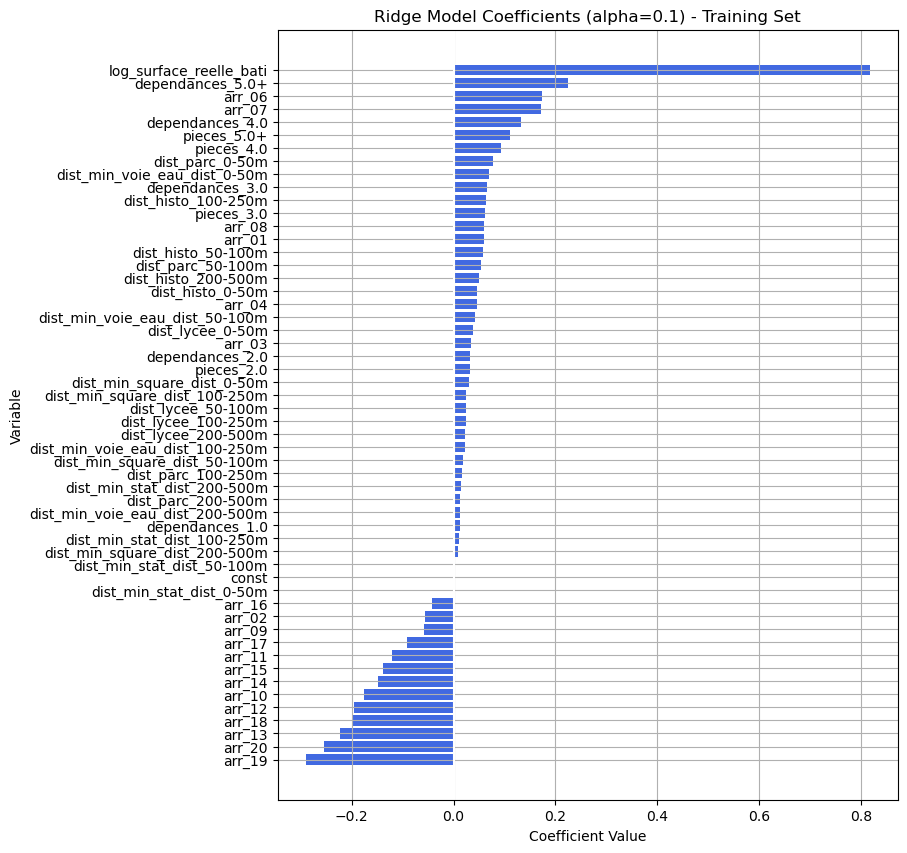

____________________________________________________
model score R² on training data: 0.9081919292532813
model score R² on testing data: 0.9086716226696389
__________________________________________________________________
Mean Absolute Percentage Error (MAPE): 0.011837332476044534
Mean Absolute Error (MAE): 0.15404390561753134
Mean Squared Error (MSE): 0.04300566061505528
Explained Variance Score: 0.9086738989763847


In [248]:
regression_ridge(X_train, y_train, X_test, y_test, var_base+var_dist+var_ind_arr, alpha=0.1)

Pour la régression RIDGE, les variables qui ont un impact négatif sur le prix, sont surtout les arrondissements. Tandis que les variables qui jouent positivement sur le prix sont le nombre de pièces, les dépendances, et la proximité aux lieux d'intérêts que nous avons ajoutés.

## **Conclusion**